In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_train_28062024.csv
/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_sample_submit_28062024.csv
/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_test_28062024.csv


## Задачи исследования

В Ходе исследования предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. 

Метрикой в этом исследовании является F1-Score. F1-мера вычисляется на основе точности p и полноты r. Точность - это отношение true positives (tp) ко всем predicted positives (tp + fp).

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'.

### Импорты и доп.пакеты

In [2]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
#установка доп пакетов и библиотек
!pip install catboost -q
!pip install sweetviz -q
!pip install phik -q


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# дополнительные импорты
from catboost import CatBoostClassifier
import sweetviz as sv
import re
from phik.report import plot_correlation_matrix
import shap

In [5]:
#константы
RANDOM_STATE = 42
TEST_SIZE = 0.3
LOAD_DATE='2018-01-01'

In [6]:
def distribution_plots(df, sign):
    """Функция для построения графиков распределения количественных признаков."""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7), dpi=100)
    sns.histplot(data=df[sign], color='darkgreen',ax=axes[0])
    sns.boxplot(data=df[sign], color='darkgreen',ax=axes[1])
    axes[0].grid(True)
    axes[1].grid(True)
    print(f'Графики распределения количественного признака "{sign}"')
    plt.show()
    print(df[sign].describe())
    print()

### Загрузка данных

In [7]:
# загрузка данных
df_train=pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_train_28062024.csv')
df_test=pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_test_28062024.csv')
df_sample=pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_sample_submit_28062024.csv')

### Осмотр данных

                                             |          | [  0%]   00:00 -> (? left)


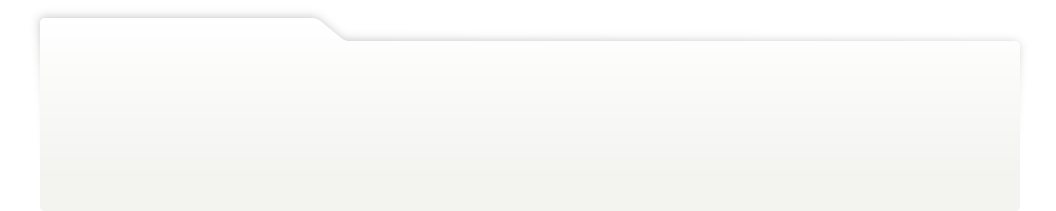
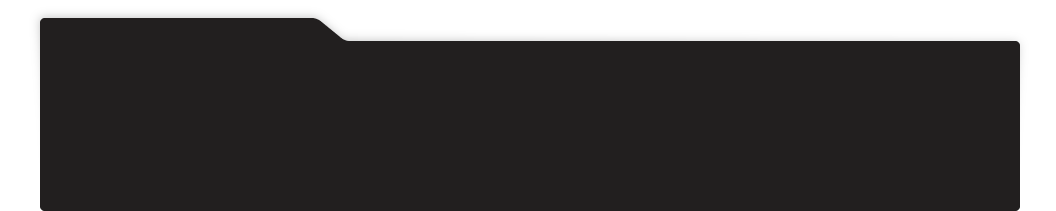
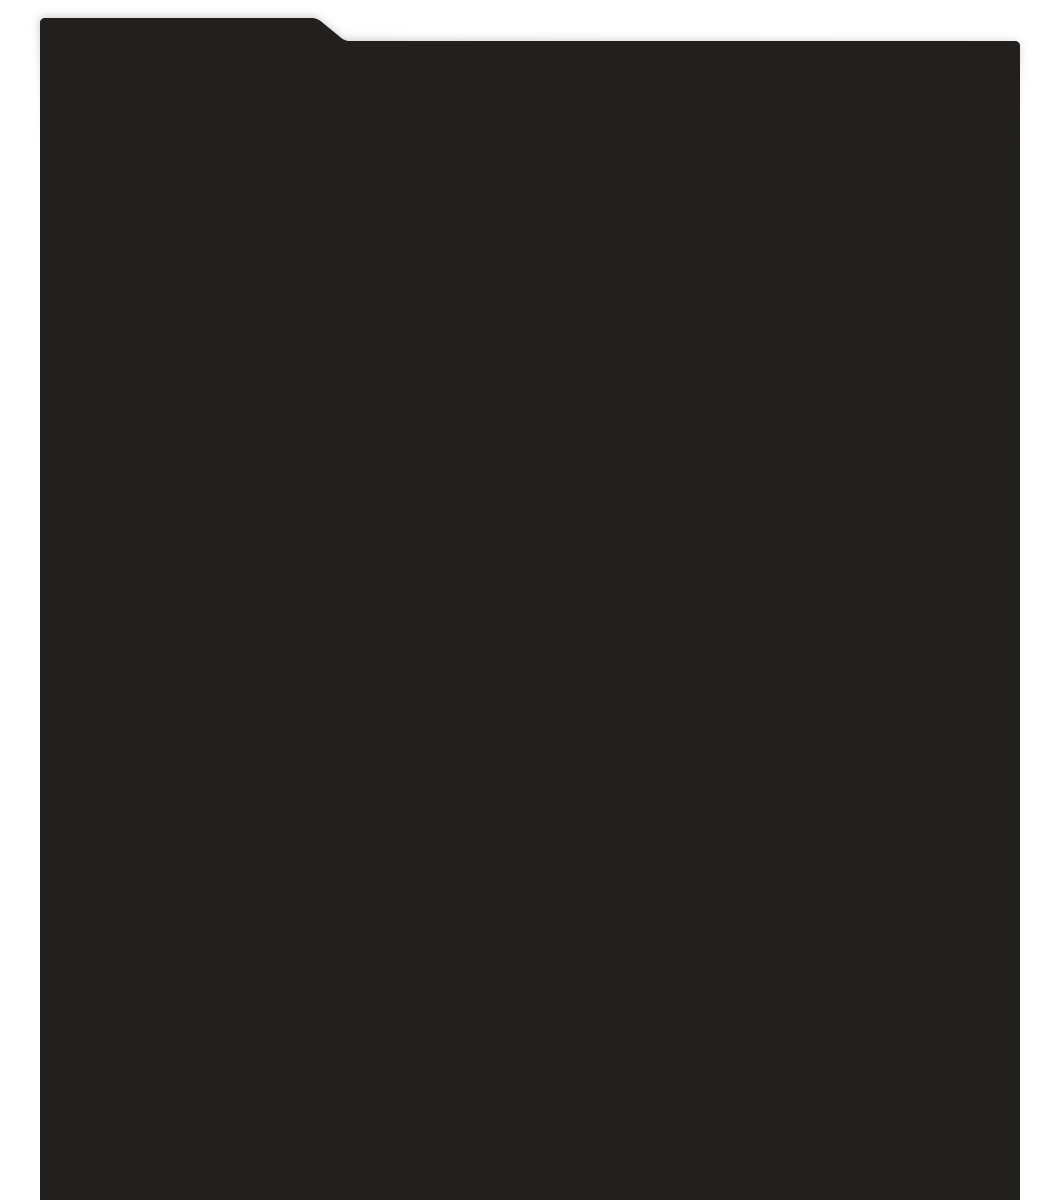
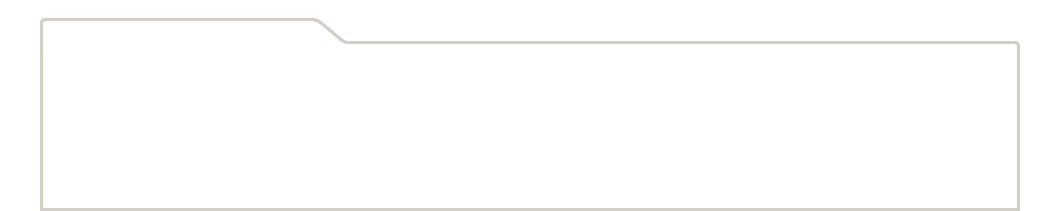
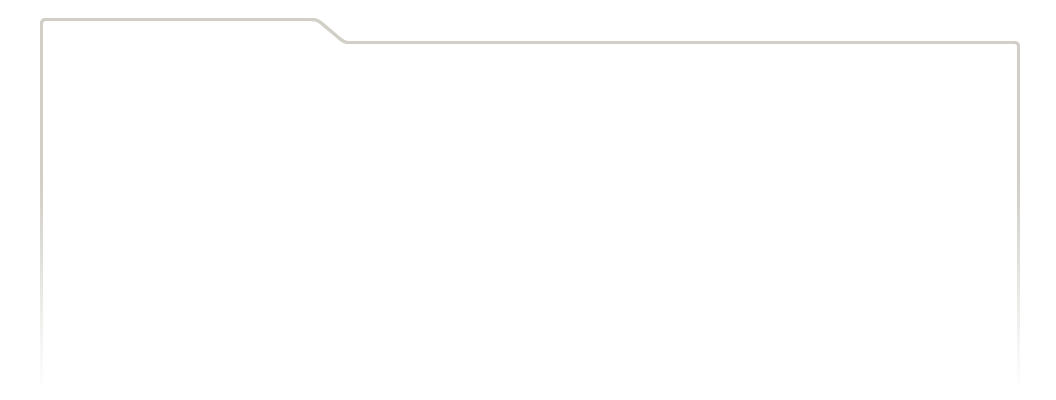
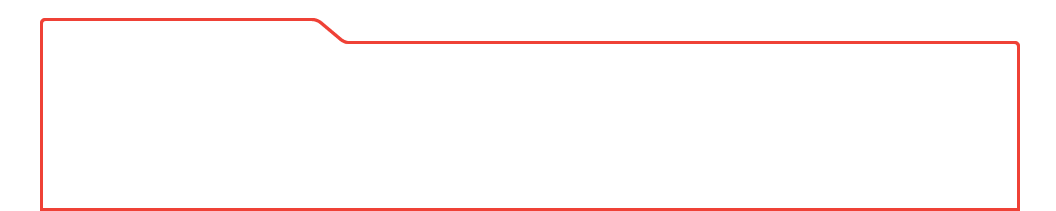
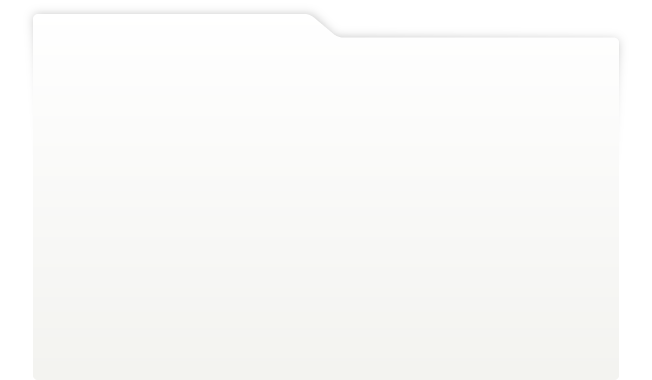
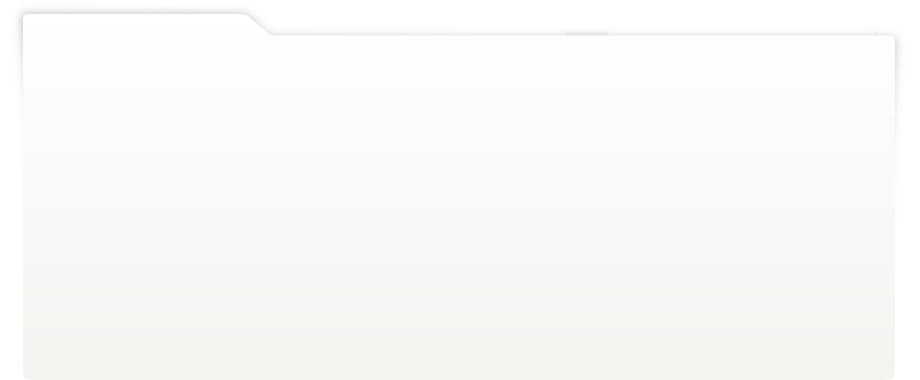
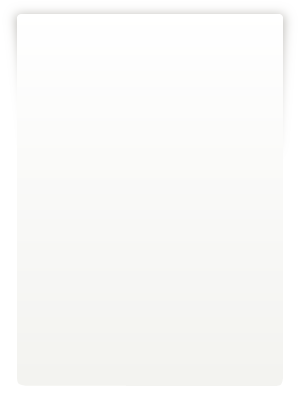
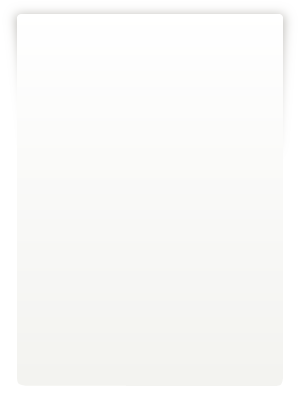
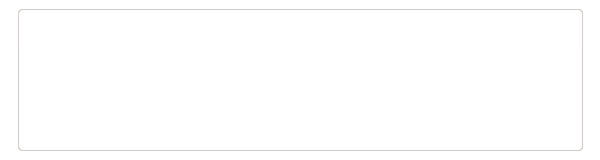
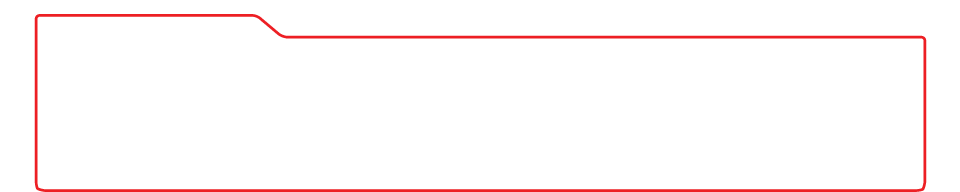
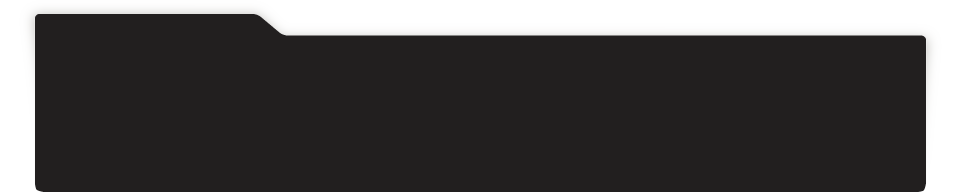
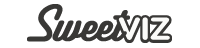
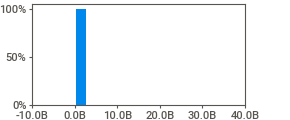
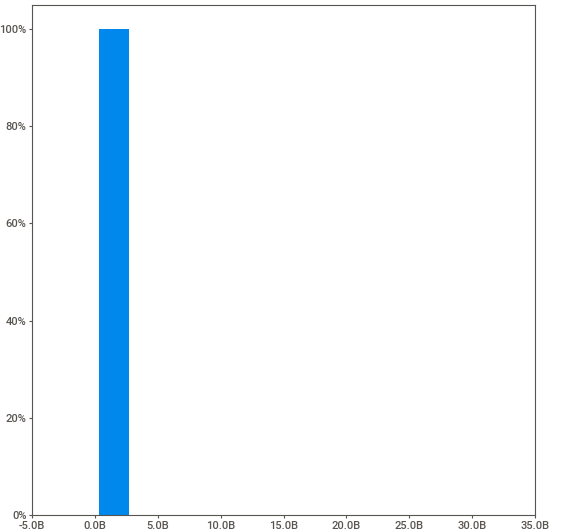
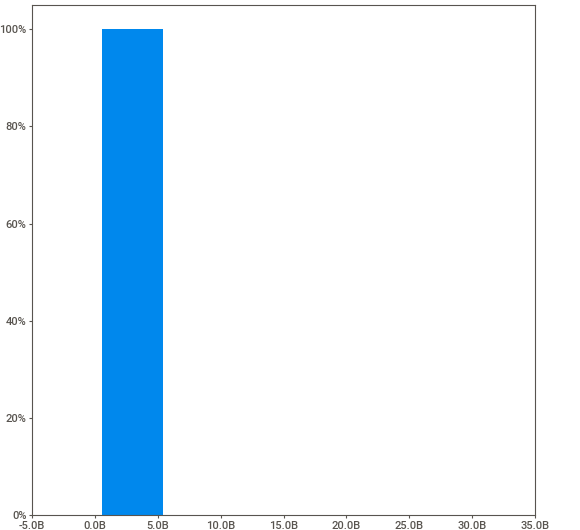
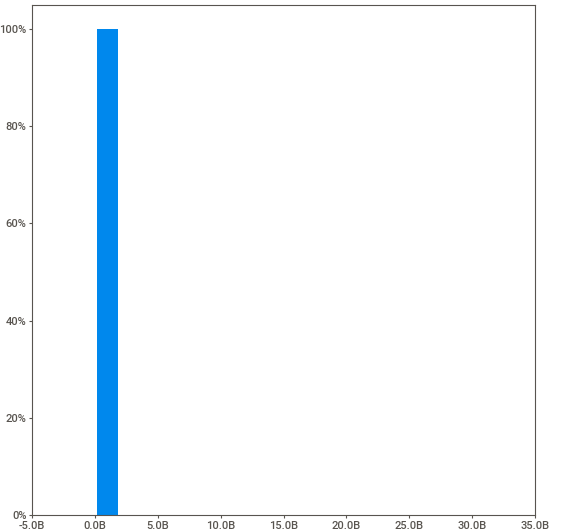
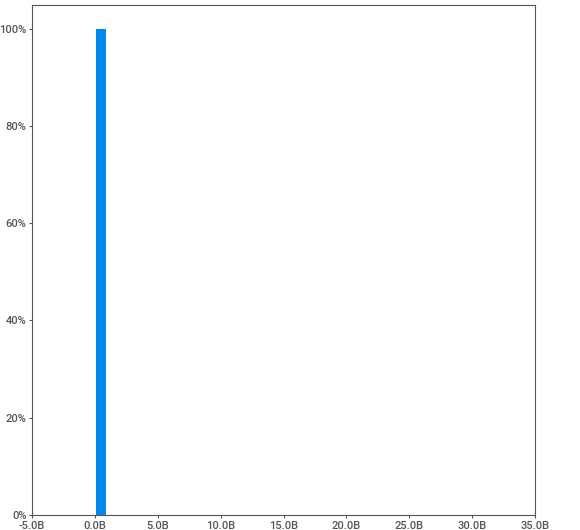
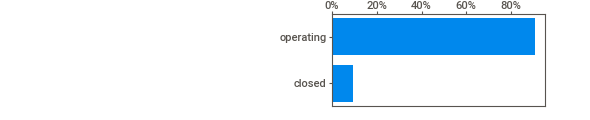
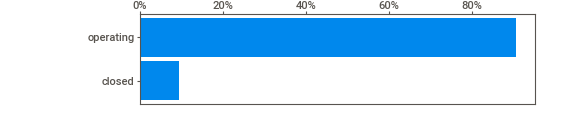
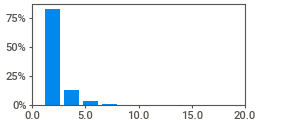
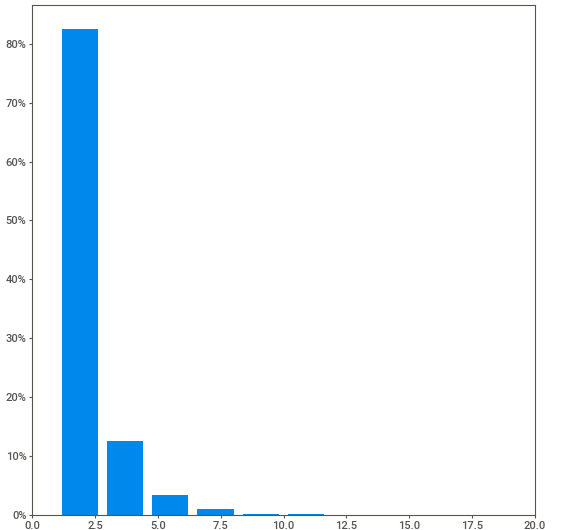
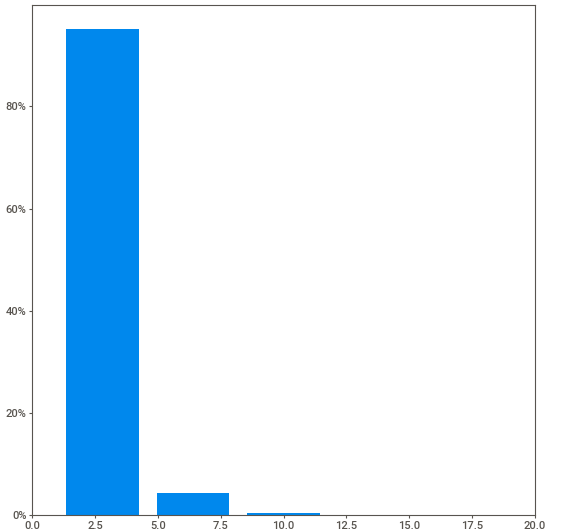
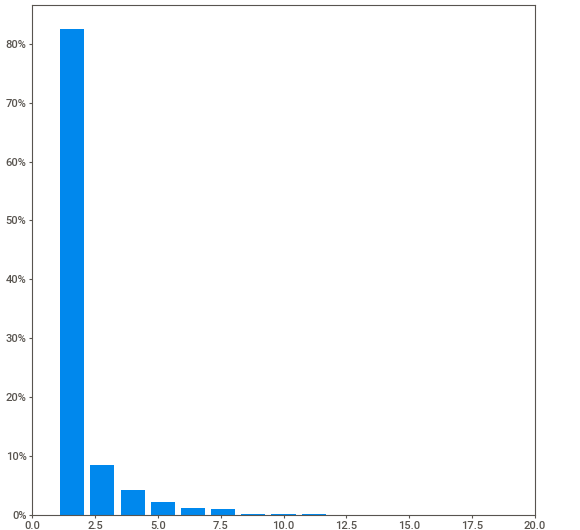
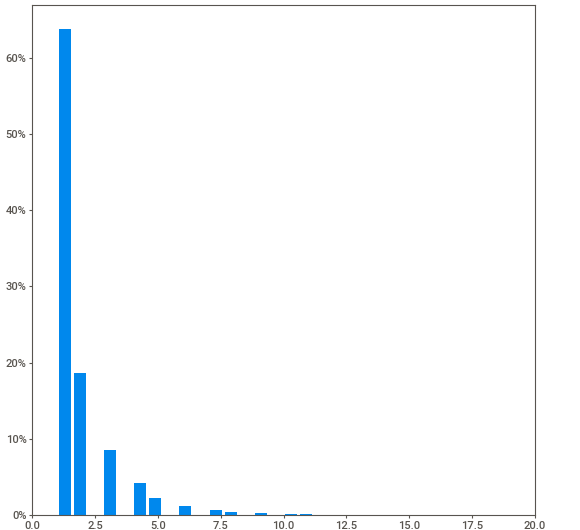
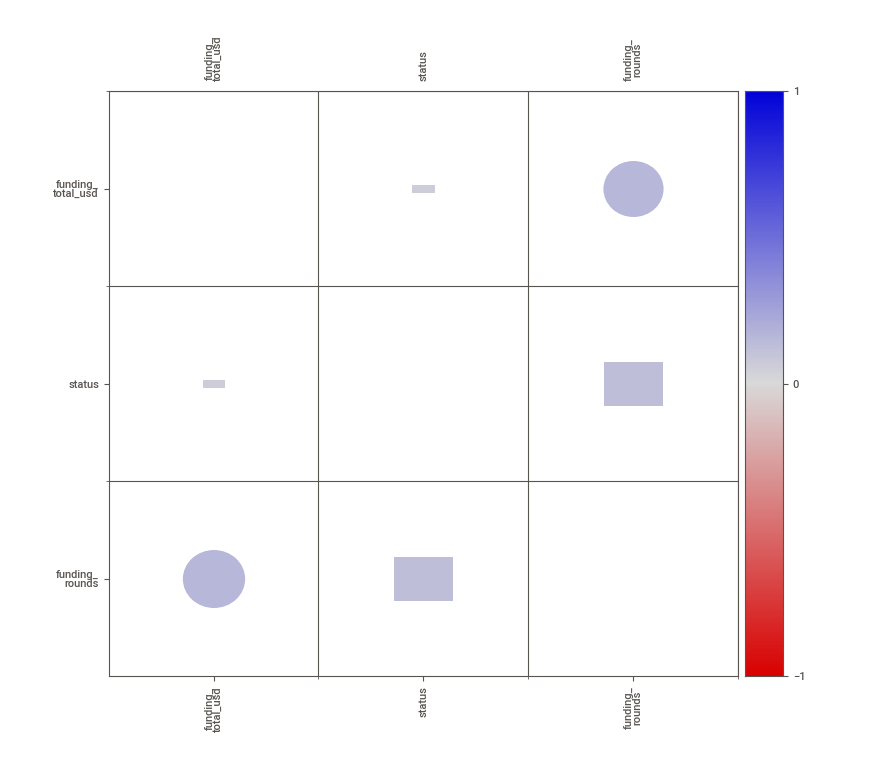
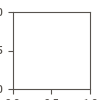

In [8]:
#осмотр и предварительный анализ данных при помощи sweetviz
report_1=sv.analyze([df_train, "Тренировочная выборка"])
report_1.show_notebook()

                                             |          | [  0%]   00:00 -> (? left)


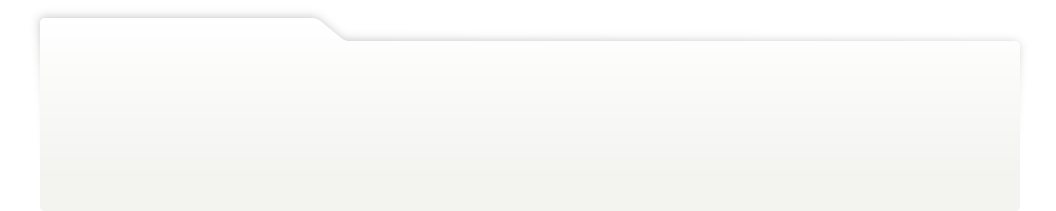
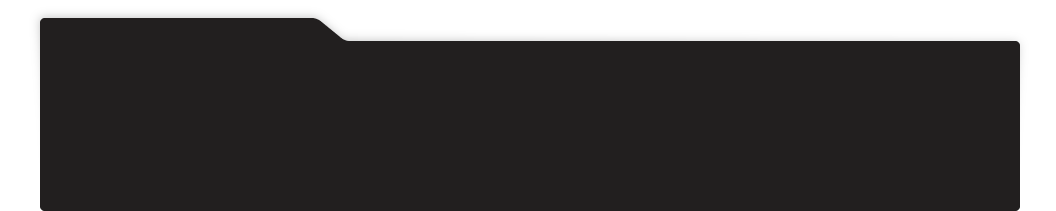
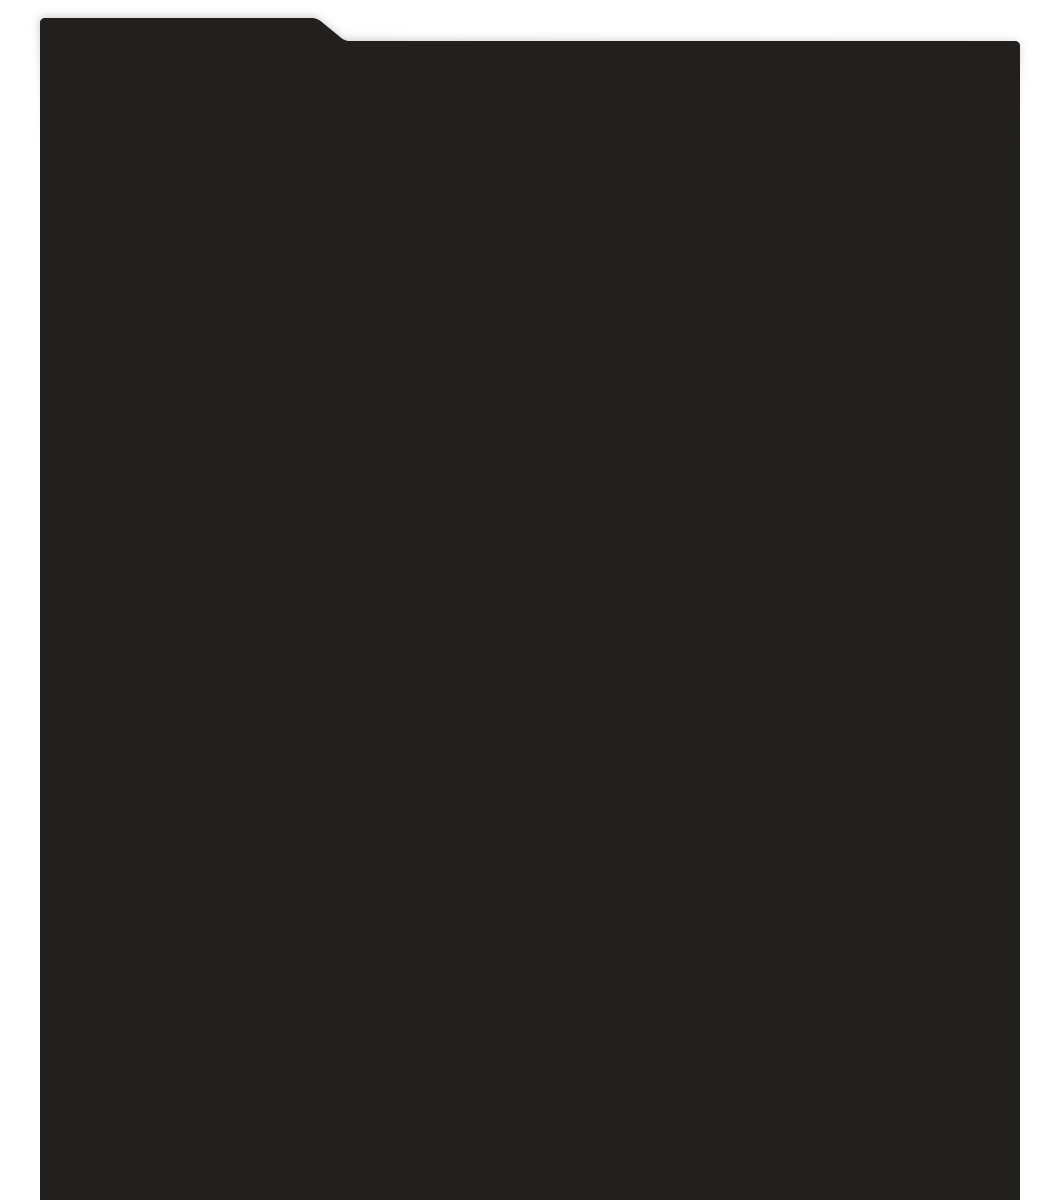
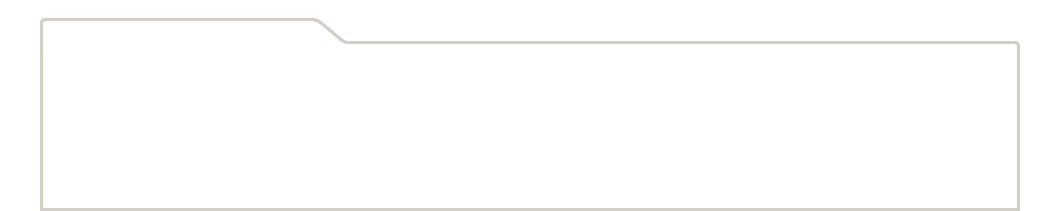
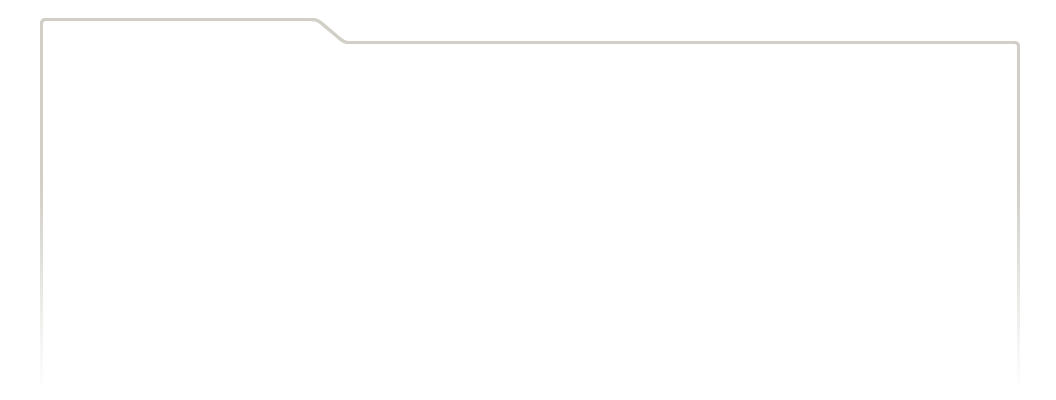
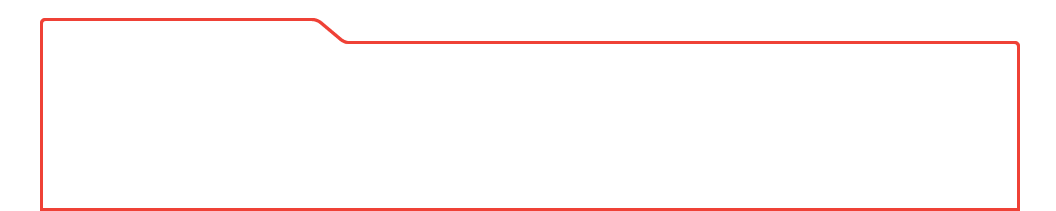
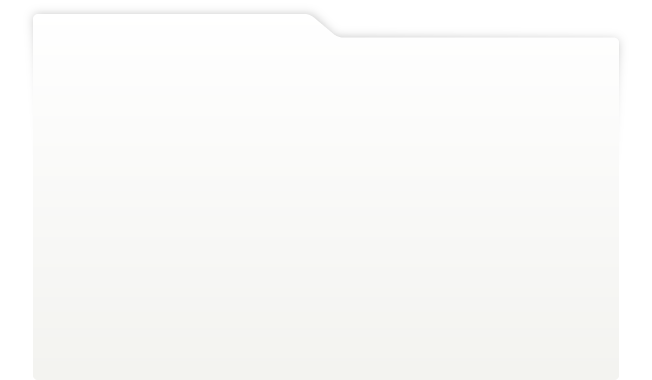
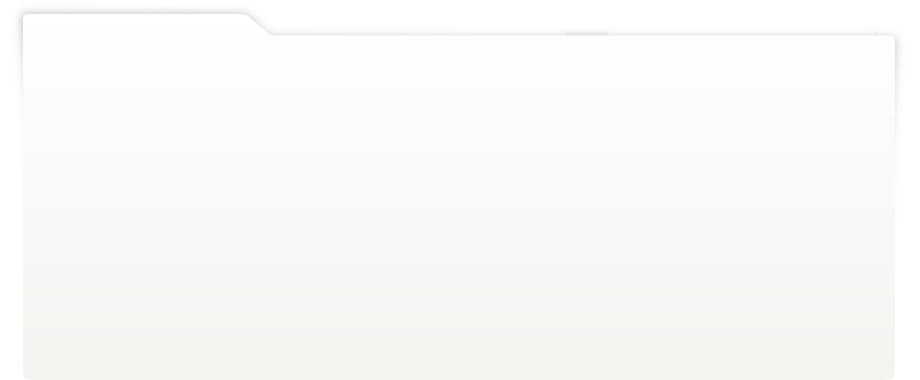
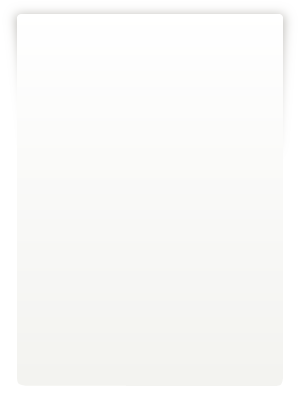
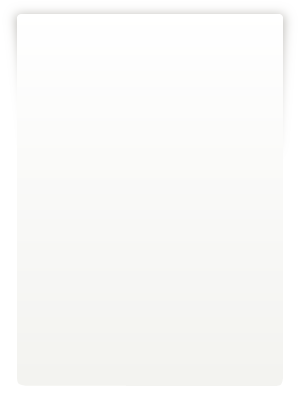
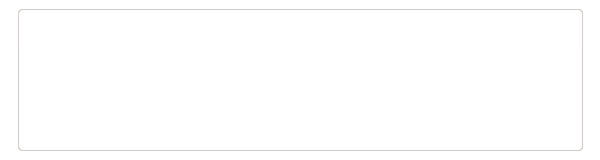
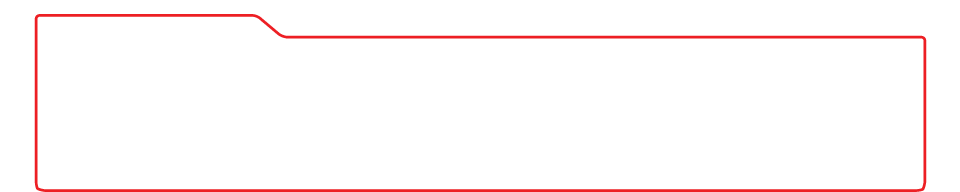
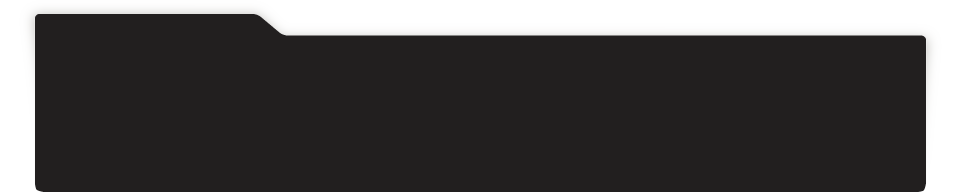
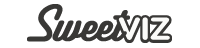
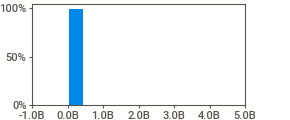
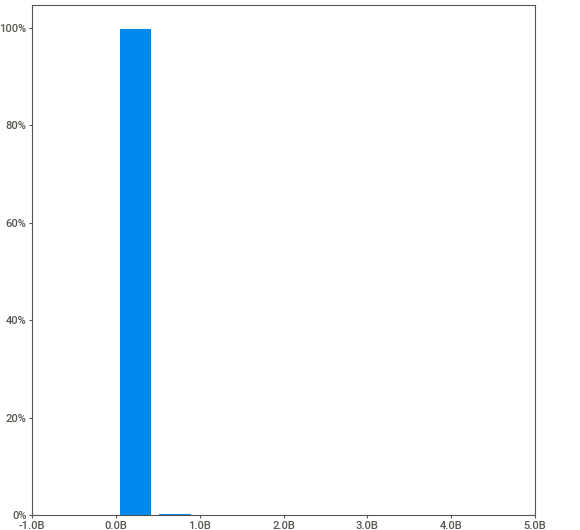
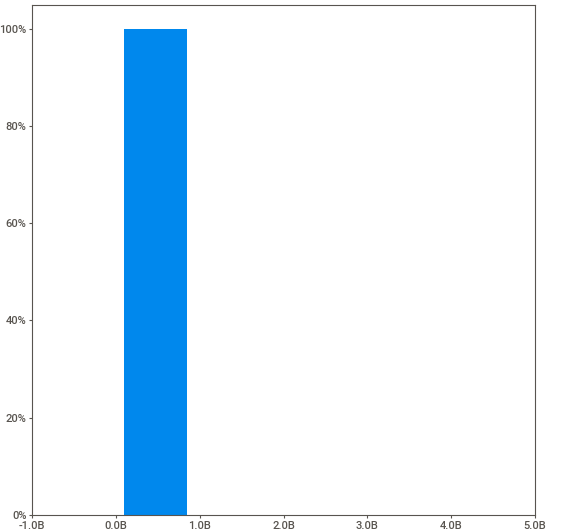
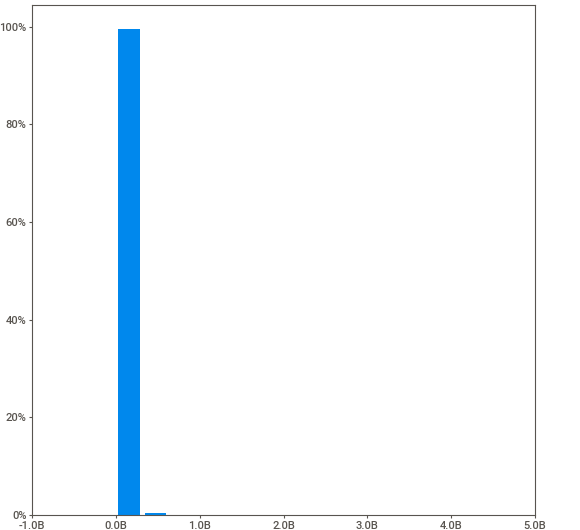
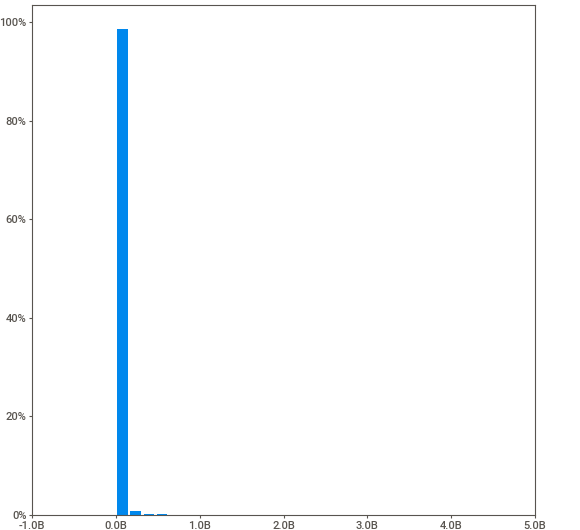
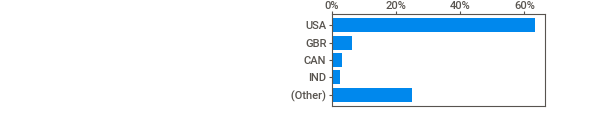
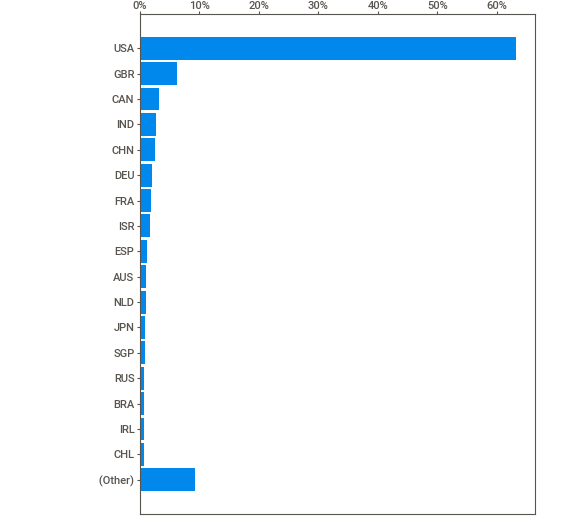
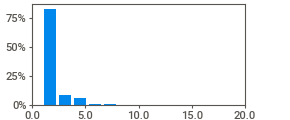
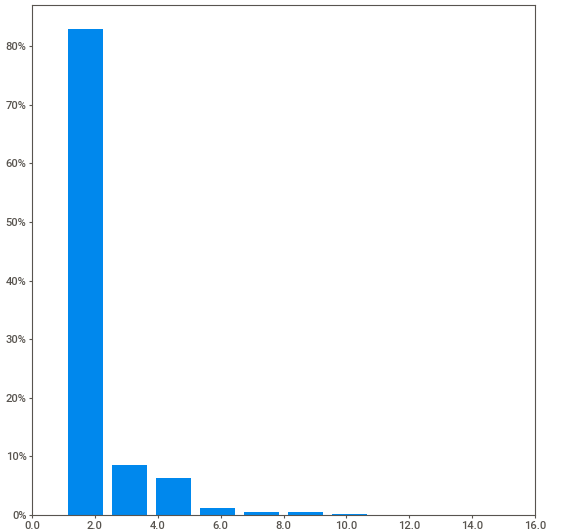
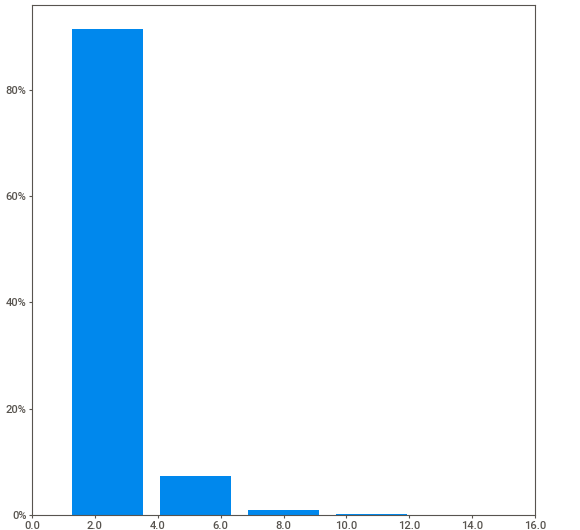
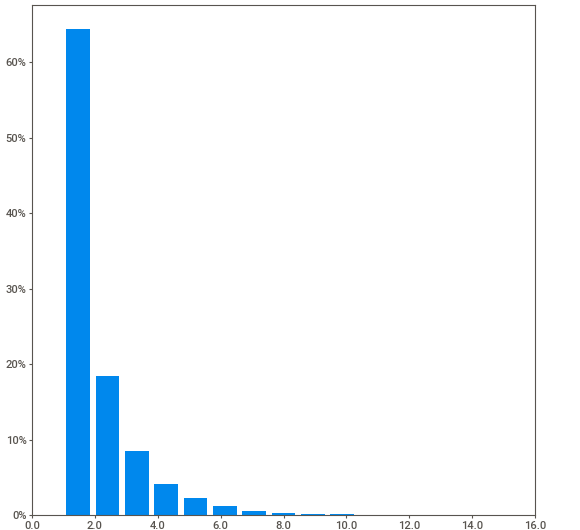
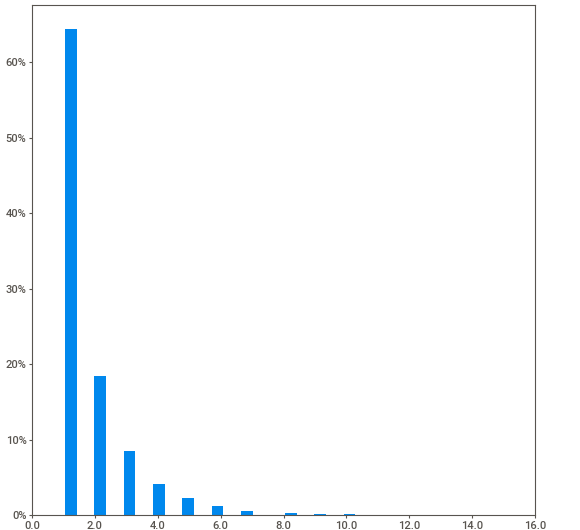
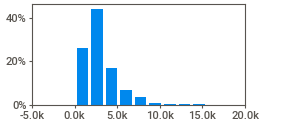
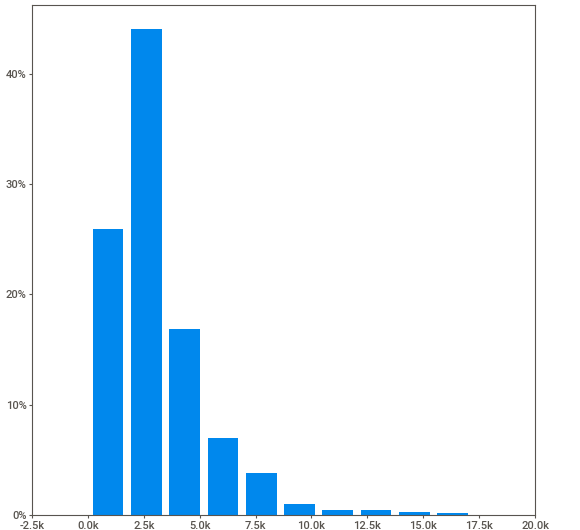
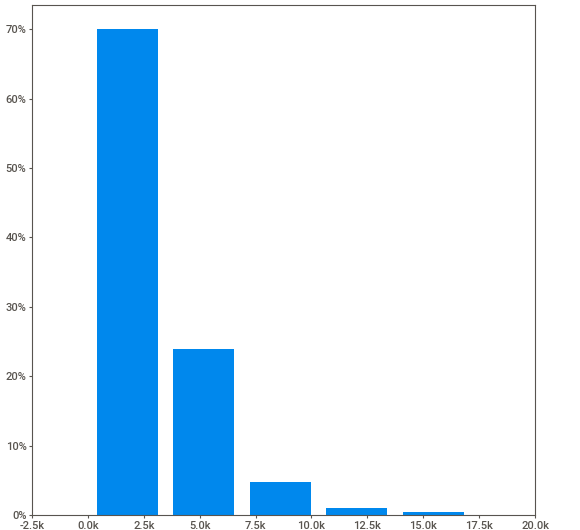
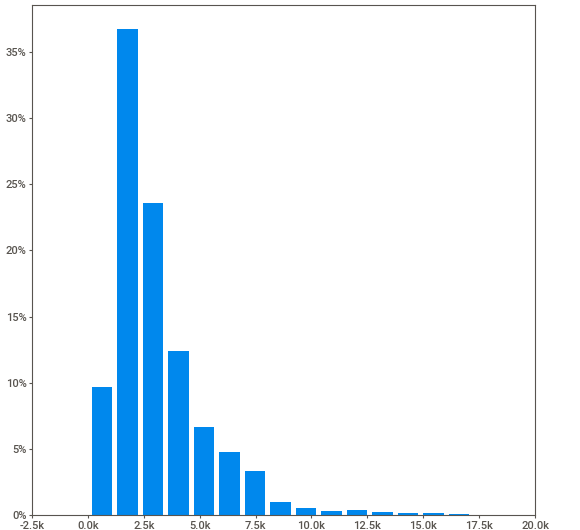
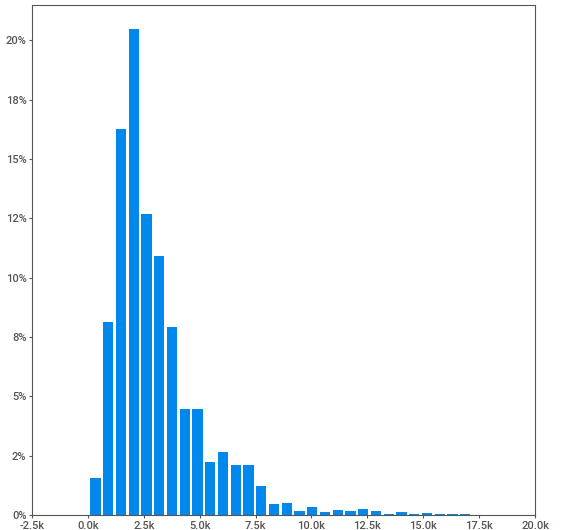
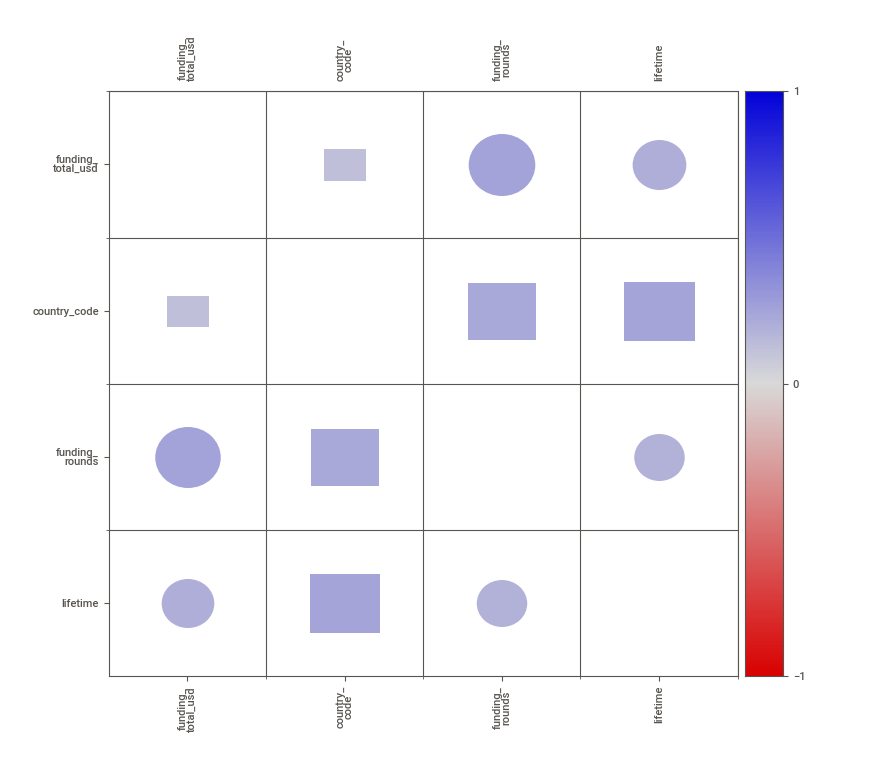
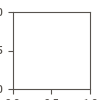

In [9]:
#осмотр и предварительный анализ данных при помощи sweetviz
report_2=sv.analyze([df_test, "Тестовые данные"])
report_2.show_notebook()

In [10]:
df_train.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

#### Предварительные выводы:
- Данные корректны, есть пропуски в колонках 'name','category_list', 'funding_total_usd', 'country_code','state_code', 'region', 'city'б которые мы обработаем в ходе исследования.
- Типизация данных невполне корректна, даны представлены в строковом формате, что так же исправим по ходу работы, переведя их в необходимый формат или же создав новые колонки с признаками.
- соотношение классов целевом признаке явно непропорционально, значит при разбинении будем использовать стратификацию.

### Предобработка данных df_train

Сразу рассмотрим строки в которых отсутствует информация об объемах финансирования, стране и категории стартапа. Данные наблюдения неинформативны и стоит исключить их из выборки.

In [11]:
df_train[df_train['category_list'].isna()&df_train['country_code'].isna()&df_train['funding_total_usd'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
64,Seamless Logistics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-02-22,2011-02-01,2011-02-01,NaN
78,Efficient Photon,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2010-02-12,2011-09-22,2011-09-22,2013-08-07
155,Public Post,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-03-04,2008-08-14,2008-08-14,2010-03-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52327,Connexions,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2010-09-24,2012-05-01,2012-05-01,NaN
52377,Maremonti,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2012-05-17,2013-08-01,2013-08-01,NaN
52394,Ogg Trading,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-26,2015-06-01,2015-06-01,NaN
52404,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30


In [12]:
drop_index=df_train[df_train['category_list'].isna()&df_train['country_code'].isna()&df_train['funding_total_usd'].isna()].index
df_train=df_train.drop(index=drop_index)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51632 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               51631 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             51632 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     51632 non-null  int64  
 9   founded_at         51632 non-null  object 
 10  first_funding_at   51632 non-null  object 
 11  last_funding_at    51632 non-null  object 
 12  closed_at          4608 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.5+ MB


In [13]:
# посмотрим на пропуск в столбце name
df_train[df_train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [14]:
#заполним этот пропуск заглушкой
df_train['name']=df_train['name'].fillna('No data')
df_train[df_train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


Обработаем признак category_list.

In [15]:
data_cat = df_train['category_list'].value_counts()
data_cat

category_list
Software                                                                                  3207
Biotechnology                                                                             2905
E-Commerce                                                                                1064
Mobile                                                                                     920
Clean Technology                                                                           892
                                                                                          ... 
iPad|Reviews and Recommendations|Social Television|Software|Television|Video on Demand       1
Graphics|Software|Startups                                                                   1
Curated Web|File Sharing|Graphics|PaaS                                                       1
Cloud Computing|Cloud Data Services|Databases|IaaS|Services|Software|Virtualization          1
Online Rental|Parking|Price Comparis

Имеем 22105 категорий для признака. При построении модели такие данные явно приведут к переобучению и отнимут слишком много врремени на обработку.
Вручную сократим количество категорий, путем поиска однокоренных слов и близких по смыслу отраслей. 

In [16]:
# возьмем список самых распространенных категорий
list_cat = data_cat[data_cat>50].index.tolist()
# уберем похожие составные названия
for x in ['Health Care', 'Health and Wellness', 'Web Hosting', 'Food Processing']:
    list_cat.remove(x)
for x in list_cat:
    if r'|' in x:
        list_cat.remove(x)
# Добавим часто встречающиеся слова и основные корни
h=['Health', 'Web', 'Finance', 'Food', 'Media', 'Data', 'Energy', 'Television',
   'Shopping', 'Bitcoin', 'Personalization', 'Fitness', 'Management', 'Innovation',
   'Online', 'Pets', 'FinTech', 'Providers', 'Charity', 'Infrastructure', 'Electrical',
    'Credit', 'Art', 'Marketplaces', 'Video', 'SaaS', 'Events', 'Startups', 'Retail',
    'Marketing', 'Home', 'Goods', 'Content', 'Databases', 'Banking', 'Offline', 'Oil',
    'Rental', 'Restaurants', 'Beauty', 'Computer', 'Water', 'Business', 'Kids', 'Gps',
    'Drones', 'Social', 'Optimization', 'Crowdfunding', 'Audio', 'Networking', 'Industrial',
     'Recruiting', 'Collaboration', 'Care', 'Delivery', 'Women', 'Farmers', 'Trading', 'Robotics',
    'Support', 'Training', 'Animal', 'Development', 'Digital', 'Translation', 'Logistics']
list_cat.extend(h)
list_cat

['Software',
 'Biotechnology',
 'E-Commerce',
 'Mobile',
 'Clean Technology',
 'Curated Web',
 'Hardware + Software',
 'Games',
 'Enterprise Software',
 'Manufacturing',
 'Advertising',
 'Education',
 'Semiconductors',
 'Real Estate',
 'Finance',
 'Consulting',
 'Social Media',
 'Security',
 'Hospitality',
 'Analytics',
 'Fashion',
 'Technology',
 'Medical',
 'Travel',
 'Internet',
 'News',
 'Sports',
 'Music',
 'Apps',
 'Messaging',
 'Pharmaceuticals',
 'Financial Services',
 'Medical Devices',
 'Information Technology',
 'Public Relations',
 'Automotive',
 'Search',
 'Transportation',
 'Photography',
 'Nanotechnology',
 'Services',
 'Design',
 'Public Transportation',
 'Telecommunications',
 'Consumer Electronics',
 'Nonprofits',
 'Entertainment',
 'Legal',
 'Health',
 'Web',
 'Finance',
 'Food',
 'Media',
 'Data',
 'Energy',
 'Television',
 'Shopping',
 'Bitcoin',
 'Personalization',
 'Fitness',
 'Management',
 'Innovation',
 'Online',
 'Pets',
 'FinTech',
 'Providers',
 'Charity',


In [17]:
def new_cat_f(cat_list, new_cat):
    """Нахождение подкатегорий в составных категориях."""
    cat=re.split(r'[|, ]', cat_list)
    for new in new_cat:
        if new in cat:
            return new
    return "Other"

In [18]:
# создаем новый признак с укрупненными категориями
df_train['new_cat']=df_train['category_list'].apply(lambda x: new_cat_f(str(x),list_cat))
new_cat = df_train['new_cat'].value_counts()
new_cat

new_cat
Software         10253
Mobile            4156
Biotechnology     3655
Other             3377
E-Commerce        3149
                 ...  
Gps                  4
Farmers              3
Women                3
Animal               2
Offline              1
Name: count, Length: 103, dtype: int64

Удалось сократить количество категорий до 103, теперь можно избавиться от самых мелких категорий.

In [19]:
# возьмем категорий в которых > 50 наблюдений
new_cat_50=new_cat[new_cat>50]
new_cat_list = new_cat_50.index.tolist()
def short_new_cat(new_cat, short_cats):
    if new_cat in short_cats:
        return new_cat
    return "Other"
df_train['new_cat']=df_train['new_cat'].apply(lambda x: short_new_cat(x,new_cat_list))
df_train.sample(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat
21509,SpamLion,Software,362500.0,operating,USA,CA,Napa Valley,Cotati,2,1996-06-01,1996-06-01,2001-02-01,NaN,Software
14039,Fitness Food Holdings,Consumer Goods|Fitness|Services,22022000.0,operating,USA,TX,Austin,Austin,1,2010-01-01,2015-07-15,2015-07-15,NaN,Services
40194,Battlepro,Games|Online Gaming,130000.0,closed,NaN,NaN,NaN,NaN,2,2012-01-01,2013-05-15,2013-05-15,2014-08-10,Games
5940,Zhan.com,Education|Training,89000000.0,operating,CHN,23,Shanghai,Shanghai,2,2010-01-01,2015-04-01,2015-11-25,NaN,Education
40427,PlayMob,Advertising|Analytics|Apps|Brand Marketing|Cause Marketing|Charity|Games|Mobile|Networking|Social Media,2183409.0,operating,GBR,H9,London,London,5,2011-07-01,2011-04-01,2014-04-01,NaN,Mobile
41866,UKDN Waterflow,NaN,NaN,operating,GBR,M2,Solihull,Solihull,1,2003-01-01,2010-01-19,2010-01-19,NaN,Other
23569,OVIVO Mobile Communications,Advertising|Mobile|Mobile Commerce|Telecommunications,2180048.0,closed,GBR,H9,London,London,5,2011-11-09,2013-03-25,2013-12-31,2015-09-29,Mobile
29568,Imagen Ltd,Cloud Data Services|Data Security|Information Technology|Media|Technology|Video|Web Development,5588898.0,operating,GBR,C3,London,Cambridge,2,1996-02-01,2014-05-28,2015-05-28,NaN,Security
22769,Moogsoft,Analytics|Enterprise Software|IT Management,21300000.0,operating,USA,CA,SF Bay Area,San Francisco,2,2011-01-01,2013-05-29,2014-10-21,NaN,Software
42928,Tipsy Elves,Design|E-Commerce|Fashion|Lifestyle,100000.0,closed,USA,CA,San Diego,San Diego,1,2011-02-01,2013-12-13,2013-12-13,2015-06-12,E-Commerce


In [20]:
print(f'Количество категорий - {len(df_train["new_cat"].value_counts())}')
df_train['new_cat'].value_counts()

Количество категорий - 60


new_cat
Software              10253
Mobile                 4156
Other                  4056
Biotechnology          3655
E-Commerce             3149
Technology             2433
Web                    1852
Health                 1726
Games                  1531
Advertising            1461
Finance                1234
Education              1214
Services               1105
Manufacturing           991
Analytics               981
Internet                948
Medical                 909
Media                   906
Security                782
Travel                  628
Consulting              587
Hospitality             508
Semiconductors          508
News                    434
Fashion                 427
Apps                    395
Music                   365
Search                  348
Sports                  337
Transportation          276
Messaging               265
Design                  257
Photography             231
Management              224
Automotive              224
Energy      

Рассмотрим признак funding_total_usd. Имеем 19% пропусков.

In [21]:
df_train[df_train['funding_total_usd'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,Manufacturing
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaN,Software
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-03-11,2008-07-15,2008-07-15,NaN,Software
34,Evargrah Entertainment Group,Entertainment|Games,NaN,operating,USA,CA,Los Angeles,Los Angeles,1,2013-08-13,2013-07-09,2013-07-09,NaN,Games
35,Bibulu,Internet|Pets|Services,NaN,operating,ESP,56,Barcelona,Barcelona,1,2013-02-01,2013-03-01,2013-03-01,NaN,Internet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,StockRadar,Finance|FinTech,NaN,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,NaN,Finance
52502,Zura!,E-Commerce,NaN,operating,BRA,27,BRA - Other,Brasil,1,2007-04-28,2008-01-01,2008-01-01,NaN,E-Commerce
52507,Proactive Comfort,Medical,NaN,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,NaN,Medical
52508,ScramCard,NaN,NaN,operating,HKG,NaN,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,NaN,Other


Рассмотрим компании у которых неизвестен обьем финансирования, статус == 'closed', и был проведен лишь один раунд финансирования. Можно предположить, что финансирование таких старпапов было нулевым, что и привело к закрытию. Заполним пропуски funding_total_usd у таких компаний 0.

In [22]:
df_train[df_train['funding_total_usd'].isna()
         &(df_train['status']=='closed')
         &(df_train['funding_rounds']==1)]=df_train[df_train['funding_total_usd'].isna()
         &(df_train['status']=='closed')
         &(df_train['funding_rounds']==1)].fillna(0)
df_train[df_train['funding_total_usd'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,Manufacturing
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaN,Software
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-03-11,2008-07-15,2008-07-15,NaN,Software
34,Evargrah Entertainment Group,Entertainment|Games,NaN,operating,USA,CA,Los Angeles,Los Angeles,1,2013-08-13,2013-07-09,2013-07-09,NaN,Games
35,Bibulu,Internet|Pets|Services,NaN,operating,ESP,56,Barcelona,Barcelona,1,2013-02-01,2013-03-01,2013-03-01,NaN,Internet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,StockRadar,Finance|FinTech,NaN,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,NaN,Finance
52502,Zura!,E-Commerce,NaN,operating,BRA,27,BRA - Other,Brasil,1,2007-04-28,2008-01-01,2008-01-01,NaN,E-Commerce
52507,Proactive Comfort,Medical,NaN,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,NaN,Medical
52508,ScramCard,NaN,NaN,operating,HKG,NaN,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,NaN,Other


Остальные пропуски заполним медианой по отрасли, к которой отнесли компанию.

In [23]:
df_train["funding_total_usd"] = df_train.groupby("new_cat")["funding_total_usd"].transform(lambda x: x.fillna(x.mean()))
df_train[df_train['funding_total_usd'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat


Обработаем 10% пропусков в колонке country_code. Отметим это как недоствточность данных.

In [24]:
df_train['country_code']=df_train['country_code'].fillna('No data')
df_train[df_train['country_code'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat


Пропуски в колонке closed_at заполним датой выгрузки для удобства дальнейших рассчетов.

In [25]:
df_train['closed_at']=df_train['closed_at'].fillna(LOAD_DATE)
df_train.sample(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat
8770,MessageGate,Messaging,1.070000e+07,closed,USA,WA,Seattle,Bellevue,3,2001-01-01,2003-08-21,2009-08-17,2011-03-25,Messaging
51424,fabrik,File Sharing|Flash Storage|Hardware + Software|Storage,5.130000e+07,operating,USA,CA,SF Bay Area,San Mateo,4,2005-08-01,2005-09-01,2007-05-01,2018-01-01,Software
47588,Genesant,NaN,1.161761e+07,operating,AUT,9,Vienna,Vienna,1,1999-01-01,2000-08-15,2000-08-15,2018-01-01,Other
14174,Personalis,Biotechnology,7.500000e+07,operating,USA,CA,SF Bay Area,Menlo Park,3,2011-08-01,2011-08-15,2015-01-13,2018-01-01,Biotechnology
10440,17zuoye,Education|Language Learning,1.350000e+08,operating,USA,VA,VA - Other,Shanghai,5,2007-01-01,2011-01-01,2015-02-19,2018-01-01,Education
24491,"World Series of Video Games, Inc",Electronics|Games|Sports|Video Games,5.000000e+05,operating,No data,NaN,NaN,NaN,1,2014-01-01,2014-09-02,2014-09-02,2018-01-01,Games
24818,Luminous Medical,Biotechnology,4.438311e+06,operating,USA,CA,San Diego,Carlsbad,2,2005-01-01,2010-09-03,2010-10-21,2018-01-01,Biotechnology
1257,TileFile,0,0.000000e+00,closed,AUS,2,Sydney,Sydney,1,2006-03-20,2007-11-16,2007-11-16,2009-03-02,Other
49819,"Grsp (fka Reela, Inc.)",Information Technology|Mobile|Mobile Commerce,4.000000e+04,operating,USA,NY,New York City,New York,1,2014-03-14,2015-06-08,2015-06-08,2018-01-01,Mobile
1793,Yingying Licai,Financial Services|Investment Management|Risk Management,1.000000e+07,operating,CHN,2,Hangzhou,Hangzhou,2,2012-10-28,2014-08-07,2014-08-08,2018-01-01,Services


In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51632 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               51632 non-null  object 
 1   category_list      50174 non-null  object 
 2   funding_total_usd  51632 non-null  float64
 3   status             51632 non-null  object 
 4   country_code       51632 non-null  object 
 5   state_code         45888 non-null  object 
 6   region             46286 non-null  object 
 7   city               46286 non-null  object 
 8   funding_rounds     51632 non-null  int64  
 9   founded_at         51632 non-null  object 
 10  first_funding_at   51632 non-null  object 
 11  last_funding_at    51632 non-null  object 
 12  closed_at          51632 non-null  object 
 13  new_cat            51632 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 5.9+ MB


#### Предварительные выводы:
- данные успешно обработаны, пропуски данных заполнены соответствеено;
- пропуски в колонках state_code, region, city не обрабатываем, так как при построении модели их не будем использовать;
- список категорий уменьшили и в моделированиии будем использовать новый столбец 'new_cat'.

### Добавление синтетических признаков в df_train

Сначала переведем в дни признаки first_funding_at, last_funding_at и добавим признак lifetime как в тестовых данных.

In [27]:
#для удобства вычислений добавим временную колонку - дата выгрузки
df_train['load_data']=LOAD_DATE
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,load_data
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Online,2018-01-01
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,2018-01-01
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,2018-01-01


In [28]:
#отобразим дату 1 раунда в днях относительно выгрузки
df_train['first_round_days']=(pd.to_datetime(df_train['load_data'])-pd.to_datetime(df_train['first_funding_at'])).dt.days
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,load_data,first_round_days
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Online,2018-01-01,2437
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,2018-01-01,2799
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,2018-01-01,1960


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Графики распределения количественного признака "first_round_days"


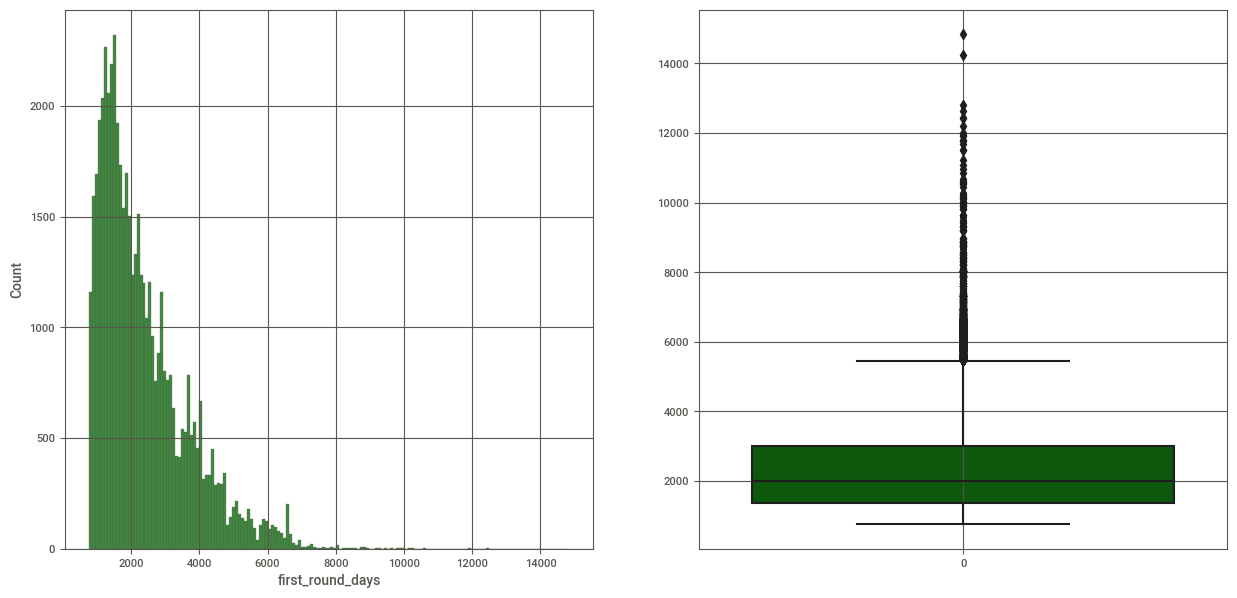

count    51632.000000
mean      2363.315134
std       1319.120036
min        758.000000
25%       1372.000000
50%       2000.000000
75%       3009.000000
max      14841.000000
Name: first_round_days, dtype: float64



In [29]:
distribution_plots(df_train, 'first_round_days')

In [30]:
#отобразим дату последнего раунда в днях относительно выгрузки
df_train['last_round_days']=(pd.to_datetime(df_train['load_data'])-pd.to_datetime(df_train['last_funding_at'])).dt.days
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,load_data,first_round_days,last_round_days
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Online,2018-01-01,2437,1127
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,2018-01-01,2799,1406
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,2018-01-01,1960,1279


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Графики распределения количественного признака "last_round_days"


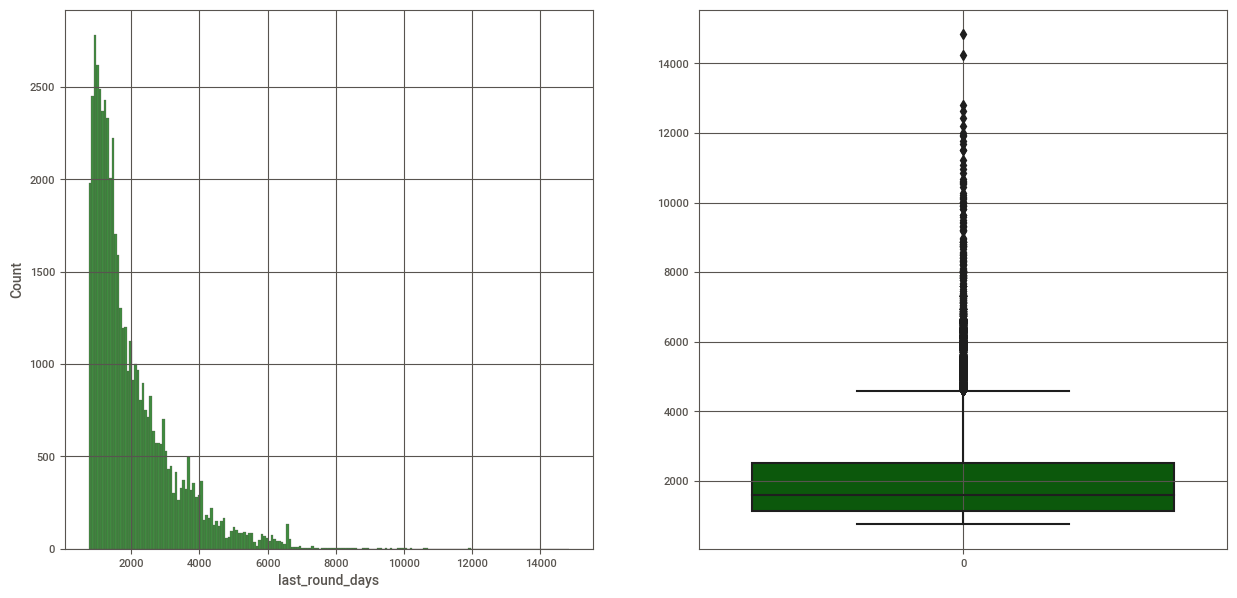

count    51632.000000
mean      2011.385691
std       1216.544319
min        756.000000
25%       1143.000000
50%       1586.000000
75%       2526.000000
max      14841.000000
Name: last_round_days, dtype: float64



In [31]:
distribution_plots(df_train, 'last_round_days')

Распределение не похоже на нормальное, видим длинный хвост справа и большое количество выбросов.

In [32]:
# добавим разницу в днях между первым и последним раундом
df_train['round_delta']=df_train['first_round_days'] - df_train['last_round_days']
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,load_data,first_round_days,last_round_days,round_delta
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Online,2018-01-01,2437,1127,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,2018-01-01,2799,1406,1393
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,2018-01-01,1960,1279,681


In [33]:
df_train['lifetime']=(pd.to_datetime(df_train['closed_at'])-pd.to_datetime(df_train['founded_at'])).dt.days
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,load_data,first_round_days,last_round_days,round_delta,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Online,2018-01-01,2437,1127,1310,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,2018-01-01,2799,1406,1393,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,2018-01-01,1960,1279,681,4383


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Графики распределения количественного признака "lifetime"


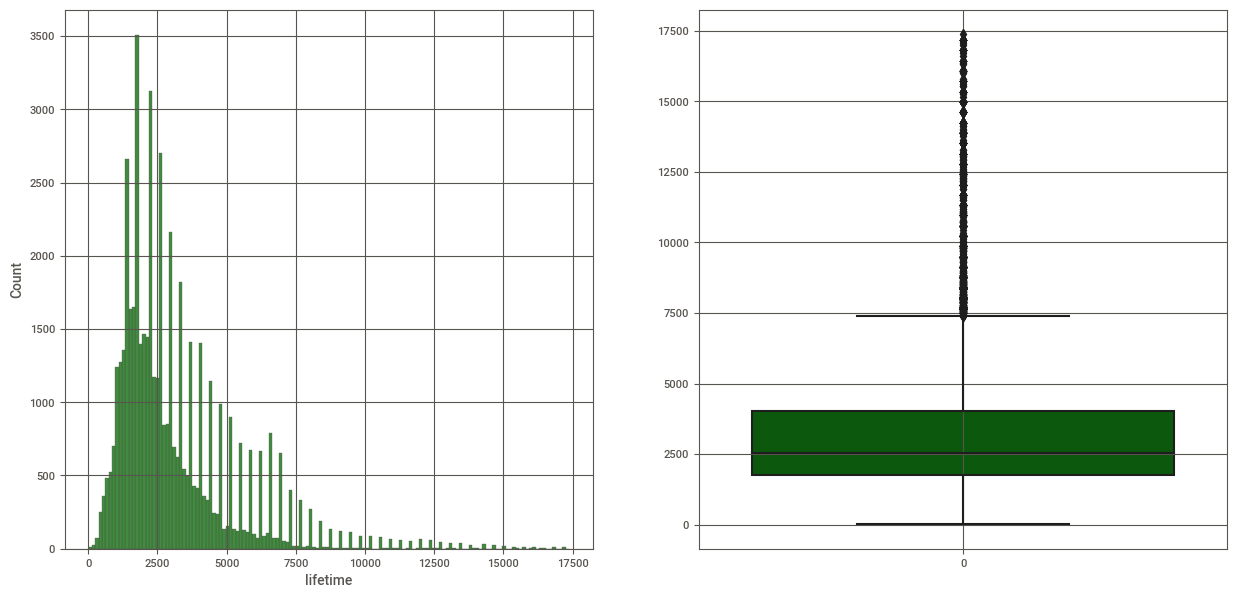

count    51632.000000
mean      3158.092966
std       2150.847796
min         19.000000
25%       1762.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64



In [34]:
distribution_plots(df_train, 'lifetime')

Распределение не похоже на нормальное, видим длинный хвост справа и большое количество выбросов.

In [35]:
df_train['funding_for_year']=df_train['funding_total_usd']/(df_train['lifetime']/365)
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,load_data,first_round_days,last_round_days,round_delta,lifetime,funding_for_year
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Online,2018-01-01,2437,1127,1310,2998,1.008834e+05
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,2018-01-01,2799,1406,1393,4748,3.300607e+06
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,2018-01-01,1960,1279,681,4383,2.952676e+06


In [36]:
# вычислим финансирование на один раунд инвестирования
df_train['finance_for_round']=df_train['funding_total_usd']/df_train['funding_rounds']
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,load_data,first_round_days,last_round_days,round_delta,lifetime,funding_for_year,finance_for_round
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Online,2018-01-01,2437,1127,1310,2998,1.008834e+05,4.143130e+05
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,2018-01-01,2799,1406,1393,4748,3.300607e+06,1.073375e+07
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,2018-01-01,1960,1279,681,4383,2.952676e+06,1.181879e+07


In [37]:
# вычислим отношение дней с последнего раунда к общей длительности существования компании
df_train['last_ratio']=df_train['last_round_days']/df_train['lifetime']
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,new_cat,load_data,first_round_days,last_round_days,round_delta,lifetime,funding_for_year,finance_for_round,last_ratio
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Online,2018-01-01,2437,1127,1310,2998,1.008834e+05,4.143130e+05,0.375917
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,2018-01-01,2799,1406,1393,4748,3.300607e+06,1.073375e+07,0.296125
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,2018-01-01,1960,1279,681,4383,2.952676e+06,1.181879e+07,0.291809


#### Предварительные выводы:
- добавлены новые синтетические признаки:
     - last_ratio - отношение дней с последнего раунда к общей длительности существования компании;
     - finance_for_round -jобьем финансирования на один раунд инвестирования,
     - funding_for_year - объем финансирования на год существования компании,
     - round_delta - разница в днях между первым и последним раундом.
- переведены в более удобный для моделирования формат признаки:
     - 'last_round_days' - "last_funding_at" выраженный в днях от даты выгрузки,
     - 'first_round_days' - "first_funding_at" выраженный в днях от даты выгрузки
- вычислен и добавлен признак lifetime, который притутствует в тестовых данных.

### Матрица корреляции

Построим, визуализируем и изучим матрицу корелляции при помощи библиотеки phik.

Сразу уберем лишние данные:
    синтетический- load_data, 
    closed_at - приведет к утечке данных,
    founded_at - нет в тестовой выборке,
    category_list - заменили на new_cat.

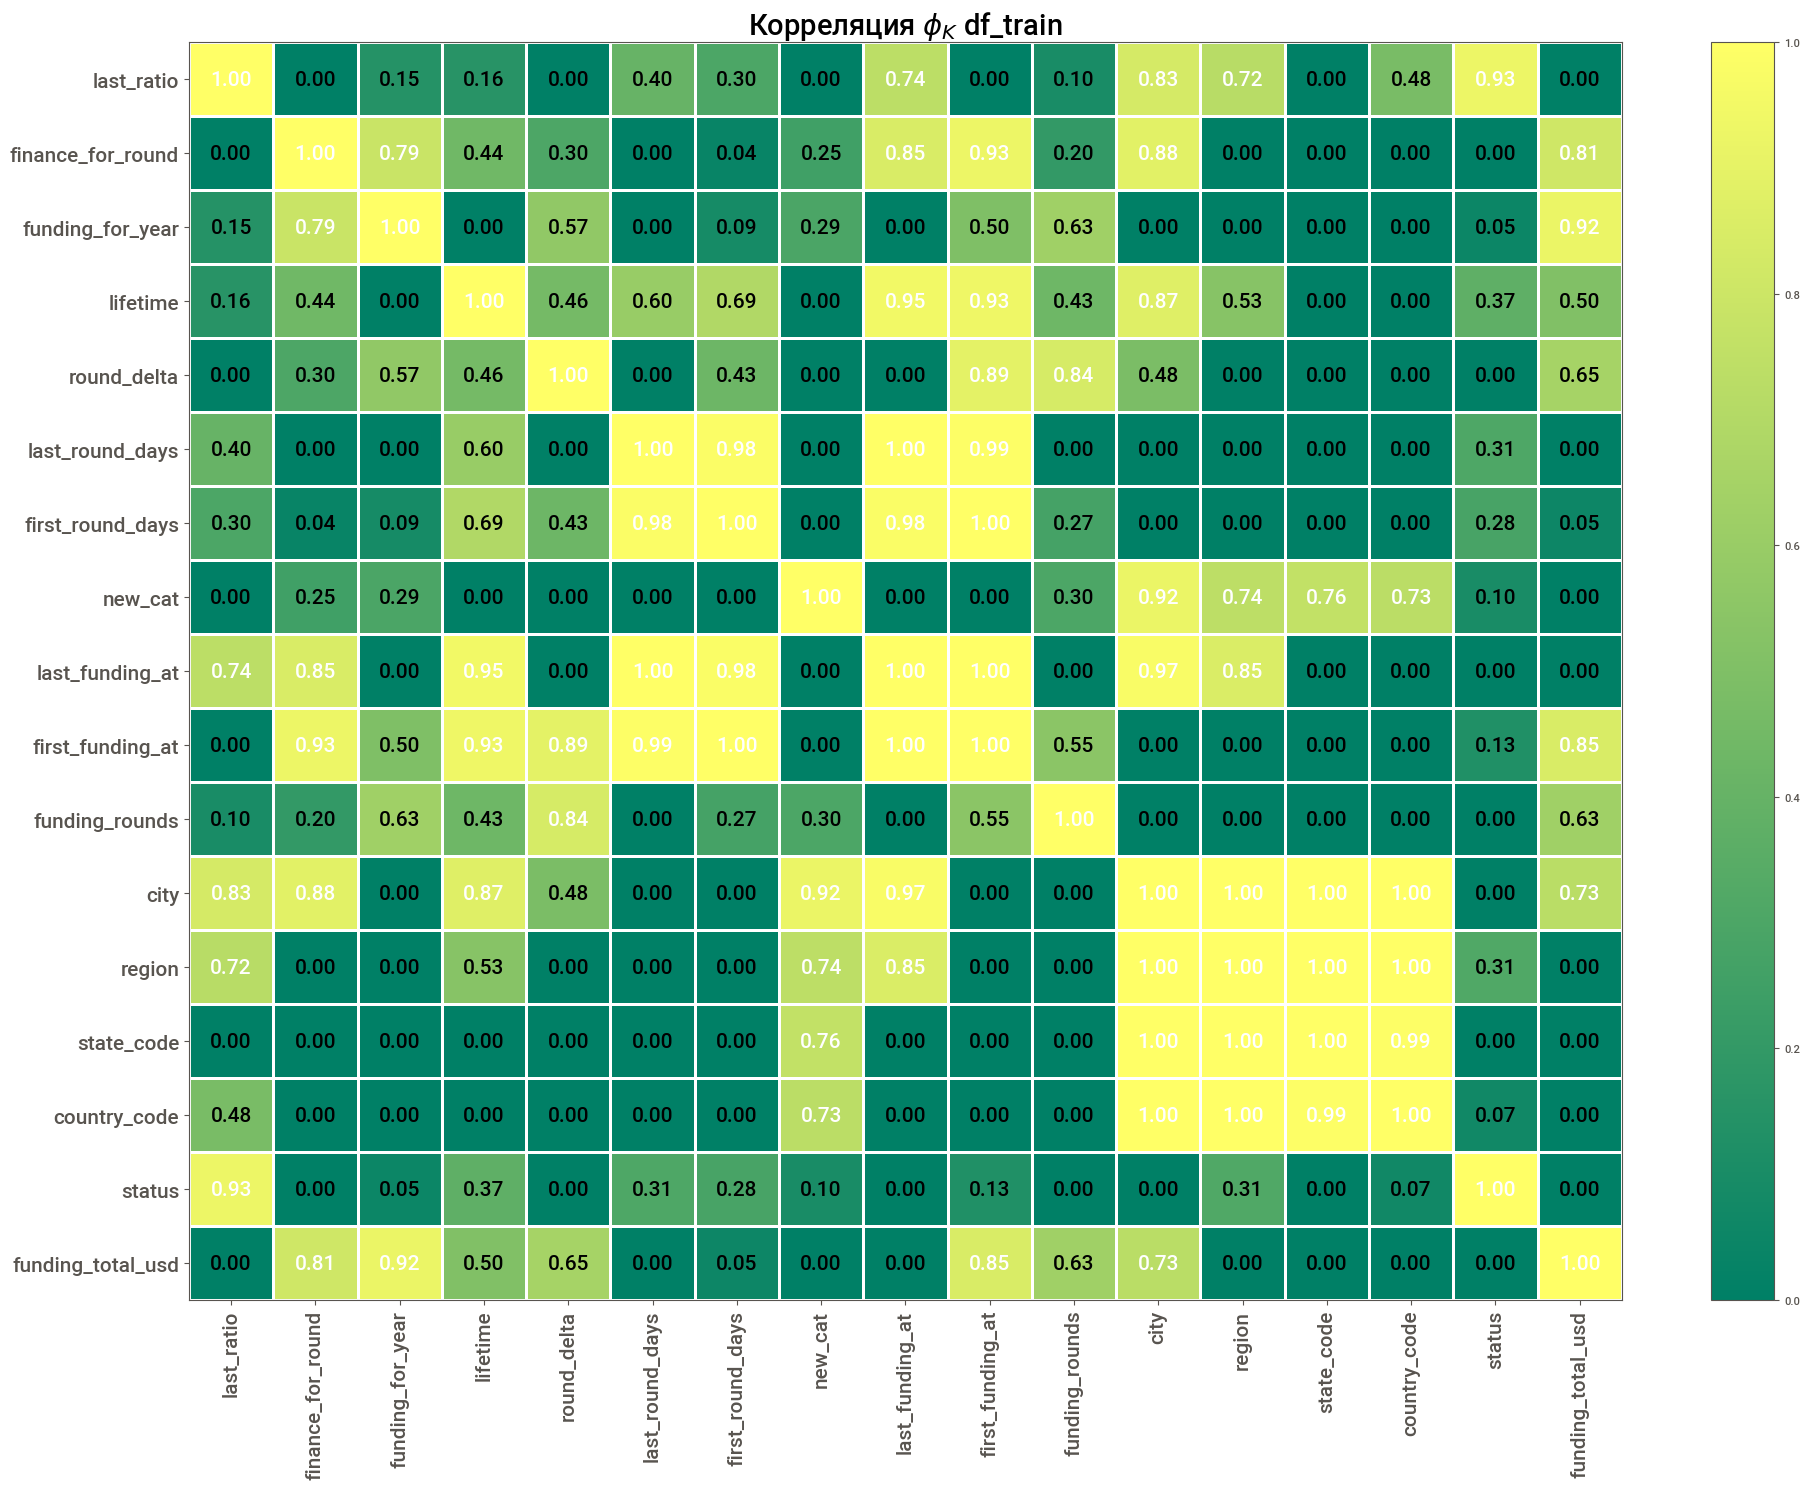

In [38]:
# возьмем часть наблюдений
df_corr, _ = train_test_split(
    df_train.drop(['name', 'load_data', 'closed_at', 'founded_at','category_list' ], axis=True),
    train_size=500,
    stratify=df_train['status'],
    random_state=RANDOM_STATE
)
phik_overview = (
    df_corr
    .phik_matrix(verbose=False, interval_cols=['funding_total_usd',
                                               'funding_rounds',
                                               'first_round_days',
                                               'last_round_days',
                                               'round_delta',
                                               'lifetime',
                                               'funding_for_year',
                                               'finance_for_round',
                                               'last_ratio'
                                              ]))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ df_train',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

О мультиколлинеарности свидетельствует значение коэффициента корреляции от 0.9 до 0.95 по модулю.
Избавимся от признаков с мультиколлинеарностью, и еще раз посмотрим на матрицу.

In [39]:
# уберем лишние признаки
col_to_drop=['name',
             'category_list',
             'state_code',
             'region',
             'city',
             'founded_at',
             'first_funding_at',
             'last_funding_at',
             'closed_at',
             'load_data',
             'first_round_days'
            ]

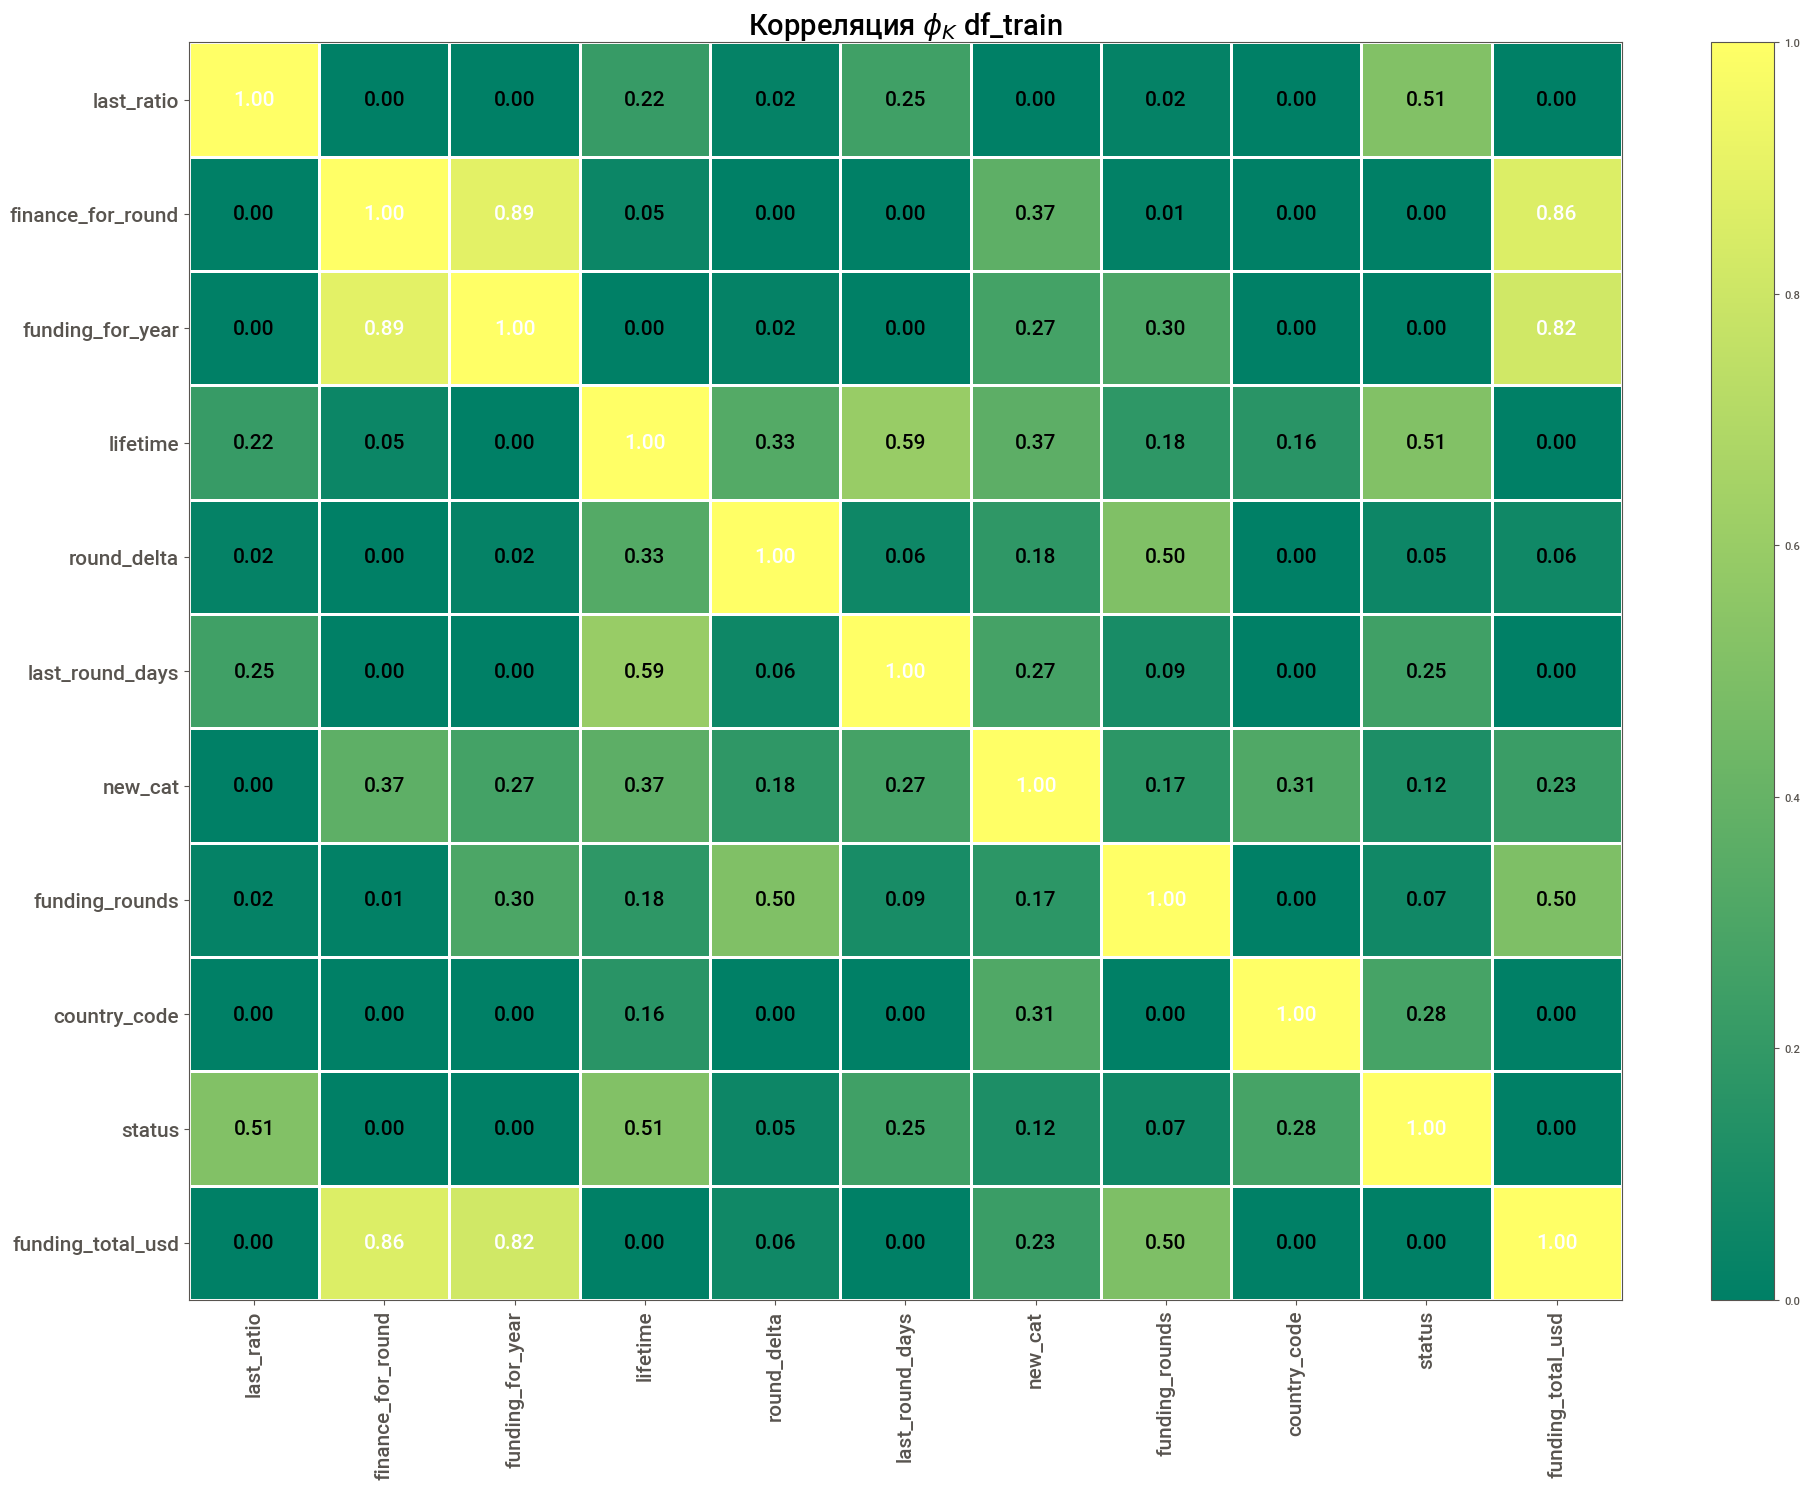

In [40]:
# возьмем часть наблюдений
df_corr_new, _ = train_test_split(
    df_train.drop(col_to_drop, axis=True),
    train_size=10000,
    stratify=df_train['status'],
    random_state=RANDOM_STATE
)
phik_overview = (
    df_corr_new
    .phik_matrix(verbose=False, interval_cols=['funding_total_usd',
                                               'funding_rounds',
                                               'last_round_days',
                                               'round_delta',
                                               'lifetime',
                                               'funding_for_year',
                                               'finance_for_round',
                                               'last_ratio'
                                              ]))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ df_train',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Предварительные выводы:
- отобрали признаки для дальнейшего моделирования, избавившись от тех, в которых могла быть утечка данных и тех, коэффициент корелляции которых был выше 0,9.
 - отобранные для дальнейшей работы с моделью признаки
                         'status' - целевой
                         'funding_total_usd',
                         'country_code',
                         'funding_rounds',
                         'new_cat',
                         'funding_for_year',
                         'finance_for_round',
                         'round_delta',
                         'lifetime',
                         'last_round_days',
                         'last_ratio'


### Предобработка данных df_test

Заполнение пропусков будем проводить аналогично тренировочной выборке.
Укрупним категории соответственно разработанному нами списку **new_cat_list**.
Отметим как отсутствие данных пропуске в стрроках country_code.
Медианным значением по отрасли заоолним пробелы в финансировании.

In [41]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [42]:
# представим дату закрытия как дату выгрузки
df_test['load_data']=LOAD_DATE
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,2018-01-01
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2018-01-01
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2018-01-01


In [43]:
df_test['country_code']=df_test['country_code'].fillna('No data')
df_test[df_test['country_code'].isna()]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data


In [44]:
# создаем новый признак с укрупненными категориями
df_test['new_cat']=df_test['category_list'].apply(lambda x: new_cat_f(str(x),new_cat_list))
df_test['new_cat'].value_counts()

new_cat
Software              2493
Other                 1209
Mobile                1140
Biotechnology          866
Technology             782
E-Commerce             716
Web                    698
Health                 614
Games                  398
Services               397
Advertising            323
Media                  321
Education              286
Finance                274
Manufacturing          243
Analytics              206
Internet               198
Security               139
Medical                128
Travel                 128
Hospitality            119
Consulting             112
Semiconductors         103
Fashion                101
Transportation          75
Management              74
Apps                    62
Search                  61
Messaging               58
Sports                  53
Music                   52
Energy                  46
News                    44
Photography             42
Automotive              41
Marketplaces            39
Goods               

In [45]:
df_test['funding_total_usd'] = df_test.groupby("new_cat")["funding_total_usd"].transform(lambda x: x.fillna(x.mean()))
df_test[df_test['funding_total_usd'].isna()]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data,new_cat


In [46]:
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data,new_cat
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,2018-01-01,Technology
1,JBI Fish & Wings,Hospitality,2.988642e+07,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2018-01-01,Hospitality
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2018-01-01,Finance


### Новые признаки для df_test

Добавим лишь часть разработанных нами для df_train новых синтетических признаков, так как матрица корелляции показалa, что не все они необходимы для использования.

In [47]:
df_test['last_round_days']=(pd.to_datetime(df_test['load_data'])-pd.to_datetime(df_test['last_funding_at'])).dt.days
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data,new_cat,last_round_days
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,2018-01-01,Technology,3106
1,JBI Fish & Wings,Hospitality,2.988642e+07,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2018-01-01,Hospitality,2714
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2018-01-01,Finance,1201


In [48]:
df_test['funding_for_year']=df_test['funding_total_usd']/(df_test['lifetime']/365)
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data,new_cat,last_round_days,funding_for_year
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,2018-01-01,Technology,3106,2.939183e+05
1,JBI Fish & Wings,Hospitality,2.988642e+07,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2018-01-01,Hospitality,2714,4.014922e+06
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2018-01-01,Finance,1201,1.207056e+05


In [49]:
df_test['finance_for_round']=df_test['funding_total_usd']/df_test['funding_rounds']
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data,new_cat,last_round_days,funding_for_year,finance_for_round
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,2018-01-01,Technology,3106,2.939183e+05,2.819200e+06
1,JBI Fish & Wings,Hospitality,2.988642e+07,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2018-01-01,Hospitality,2714,4.014922e+06,2.988642e+07
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2018-01-01,Finance,1201,1.207056e+05,2.141285e+05


In [50]:
df_test['round_delta']=(pd.to_datetime(df_test['last_funding_at'])-pd.to_datetime(df_test['first_funding_at'])).dt.days
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data,new_cat,last_round_days,funding_for_year,finance_for_round,round_delta
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,2018-01-01,Technology,3106,2.939183e+05,2.819200e+06,0
1,JBI Fish & Wings,Hospitality,2.988642e+07,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2018-01-01,Hospitality,2714,4.014922e+06,2.988642e+07,0
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2018-01-01,Finance,1201,1.207056e+05,2.141285e+05,126


In [51]:
df_test['last_ratio']=df_test['last_round_days']/df_test['lifetime']
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data,new_cat,last_round_days,funding_for_year,finance_for_round,round_delta,last_ratio
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,2018-01-01,Technology,3106,2.939183e+05,2.819200e+06,0,0.887175
1,JBI Fish & Wings,Hospitality,2.988642e+07,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2018-01-01,Hospitality,2714,4.014922e+06,2.988642e+07,0,0.998896
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2018-01-01,Finance,1201,1.207056e+05,2.141285e+05,126,0.927413


## Моделирование

При исследовани данных нами было обнаружено, что соотношение классов во вхоодном признаке 'status' непропорционально.

- 'closed' - 9%
- 'operating' - 91%
В связи с этим для сохранения баланса классов в выборках используем стратификацию.

Для кодирования целевого признака воспользуемся LabelEncoder.

Так как у нас два сложных категориальных признака new_cat(60 категорий) и country_code(134 категории), то испотзьзем модель CatBoostClassifier, которая хорошо подходит для таких задач и не нуждается в предварительном кодировании признаков.


In [52]:
df_train_model_new=df_train[['funding_total_usd',
                         'status',
                         'country_code',
                         'funding_rounds',
                         'new_cat',
                         'funding_for_year',
                         'finance_for_round',
                         'round_delta',
                         'lifetime',
                         'last_round_days',
                         'last_ratio'
                        ]]
# Разбивка данных
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_train_model_new.drop('status', axis=True),
                                                    df_train_model_new['status'],
                                                    stratify=df_train_model_new['status'],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)
lb_encoder_new = LabelEncoder()
# кодирование целевого признака
lb_encoder_new.fit(y_train_new)
y_train_new=lb_encoder_new.transform(y_train_new)
y_test_new=lb_encoder_new.transform(y_test_new)

In [53]:
# Явное указание категориальных признаков
cat_features_new = ['country_code', 'new_cat']
# Создание и обучение модели с указанием категориальных признаков
model_new = CatBoostClassifier(iterations=1000, learning_rate=0.15, depth=6, logging_level='Silent')
model_new.fit(X_train_new, y_train_new, cat_features=cat_features_new)

# Оценка производительности модели
y_test_pred_new = model_new.predict(X_test_new)
print(f'Метрика f1 на тестовой выборке: {f1_score(y_test_new, y_test_pred_new)}')

Метрика f1 на тестовой выборке: 0.9903378235418576


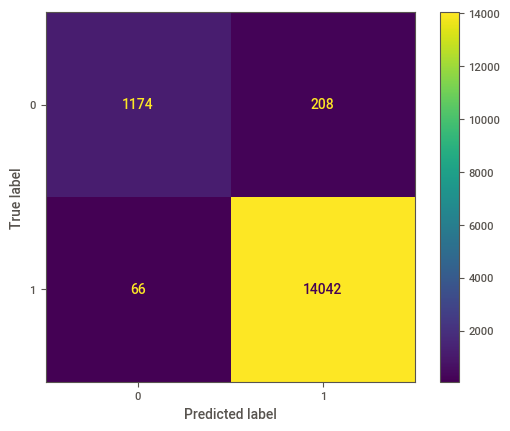

In [54]:
ConfusionMatrixDisplay.from_estimator(model_new, X_test_new, y_test_new)

Модель показывает очень высокую метрику F1 и в целом работает неплохо. Класс(0) она определяет значительно хуже, но учитывая большой дисбаланс классов и не самую удачную обработку нами категориальных признаков(возможно стоило воспользоваться векторизацией относительно признака category_list)б будем считать эту модель успешной. 
Возспользуемся ей для предсказания на тестовой выборке.

In [55]:
x_test_model_new=df_test[['funding_total_usd',
                         'country_code',
                         'funding_rounds',
                         'new_cat',
                         'funding_for_year',
                         'finance_for_round',
                         'round_delta',
                         'lifetime',
                         'last_round_days',
                         'last_ratio']]
x_test_model_new.head(3)

,funding_total_usd,country_code,funding_rounds,new_cat,funding_for_year,finance_for_round,round_delta,lifetime,last_round_days,last_ratio
0,2.819200e+06,NIC,1,Technology,2.939183e+05,2.819200e+06,0,3501,3106,0.887175
1,2.988642e+07,USA,1,Hospitality,4.014922e+06,2.988642e+07,0,2717,2714,0.998896
2,4.282570e+05,LUX,2,Finance,1.207056e+05,2.141285e+05,126,1295,1201,0.927413


In [56]:
predict_new=model_new.predict(x_test_model_new)
predict_lb_new=lb_encoder_new.inverse_transform(predict_new)
df_test['status_new']=predict_lb_new
df_test.head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,load_data,new_cat,last_round_days,funding_for_year,finance_for_round,round_delta,last_ratio,status_new
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,2018-01-01,Technology,3106,2.939183e+05,2.819200e+06,0,0.887175,operating
1,JBI Fish & Wings,Hospitality,2.988642e+07,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2018-01-01,Hospitality,2714,4.014922e+06,2.988642e+07,0,0.998896,operating
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,2018-01-01,Finance,1201,1.207056e+05,2.141285e+05,126,0.927413,operating


In [57]:
df_test['status_new'].value_counts()

status_new
operating    12047
closed        1078
Name: count, dtype: int64

На платформе kaggle метрика f1 на тестовых данных показала результат **0,87619**.

In [60]:
#выгрузка для соревнования
#answer_new=df_test[['name', 'status_new']]
#answer_new.rename(columns = {'status_new':'status'}, inplace = True)
#answer_new.head(30)
#answer_new.to_csv('answer_v8.csv', index=False)

### Анализ важности признаков

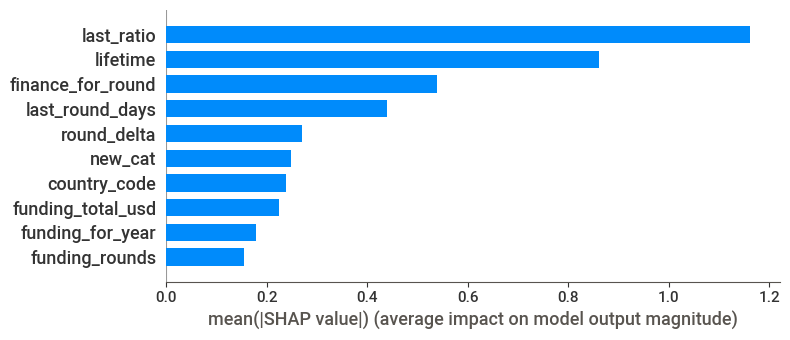

In [65]:

# Explain feature importance using SHAP
explainer = shap.Explainer(model_new)
shap_values = explainer.shap_values(X_test_new)
 
# Create a summary plot
shap.summary_plot(shap_values, X_test_new, plot_type="bar", plot_size= 0.2)
plt.show()

На графике видим, что модель основывает свои предсказания на количественных признаках lifetime, finance_for_round и last_round_days. Возмоджно прилушней обработке категориальных признаков - категории и код_страны - мы бы получили куда лучший результат. Необходимо рассмотреть в дальнейшем возможность векторизовать значения через word2vec или sentense-transformers.

## Отчет о проделанной работе и итоговые выводы:

 - загружены имеющиеся данные из файлов;
 - проведен анализ данных при помощи библиотеки sweetviz:
    - исправлены некорректные данные;
    - исправлена типизация данных для лучшей обрабатываемости;
    - добавлены синтетические признаки для лучшего обучения модели;
    - проведен корреляционный анализ на основе которого отобраны лучшие признаки;
 - использована модель CatBoostClassifier для решения поставленной задачи:
    - значение метрики f1 на тестовых данных на платформе Kaggle - 0,876
 - проанализировали важность признаков для задачи :
    - наиболее важными признаками для модели выделены: 
        - отношение количества дней с последнего раунда к времени существования компании в днях,
        - общее время существования компании,
        - обьем финансирования на один раунд.
Для дальнейшего улучшения качества модели:
    - стоит рассмотреть механизмы автоматической генерации синтетических признаков;
    - возможность векторизовать значения категориальных признаков через word2vec или sentense-transformers;
    - рассмотреть SMOTENC и гиперпараметра class_weight для учета дисбаланса классов в целевой переменной;
    - глубже изучить предметную область инвестирования стартапов для разработки дополнительных признаков и разбиений на категории.  

